<a href="https://colab.research.google.com/github/saltyj99/Digital-Chemistry-Project-7/blob/main/DC_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Digital Chemistry Project 7:
 Machine Learning-Based Prediction of Elution Time
Under Variable Chromatographic Conditions

README:
Here we neet to explain the
project's purpose, structure, and setup instructions.

The purpose of the project is to create a model, which can predict the elution times of certain molecules for high performance liquid chromatography (HPLC). Hereby, it should especially be able to adapt to differnces in flow rate and solvent composition. The project is structured such that at first data of around 300 molecules is listed and sorted, which is later used to train our models. The models in question are LASSO, Random Forest and Ridge Regression. When assessing the performance of the different models, different dataset splits are used in order to gain an understanding of what is the best set up. Lastly, the results are compared by looking at the average residual error and then making assumptions about the best model available.

-split
-standrisieren
-cross validation


In [ ]:

"""
TO DO:
Set seed for CV: (Yikuan: scheint ok zu sein. Hab bei ridge noch (max_iter=10000, random_state=42) hinzugefügt)
eventuell säulen in plots nach performance sortieren
Feature importance of random forest✅
model für dataset_all ✅


Next steps:
  - Decide on curation ✅
  - Decide on how to represent gradient elution program ✅

  - Split data (Random or by certain criteria) -> Jule
  - (Standardize descriptors) -> Jule

  We can do simpler models that only looks at a single molecule or column setting, and/or more complex models that look at all the data.
  - Choose ML model✅
      - Linear regression : nochmal prüfen ob das alles so stimmt
          - Ridge regression ✅
          - Lasso regression ✅
      - Random forest ✅
      - (Neural Network for all the data if someone is interested)
  - Train model ✅
  - Cross Validation  -> Jule ✅
  - Dummy model -> Lecture 4 ~p.63

  Yikuan:
  - Evaluate models
  - Visualize and explain results -> L3, L10
      - Principle component analysis (to see which descriptors matter)
      - Coeficients of linear regression models -> needs standardization to be comparable
          - be aware of corelation! -> L4, L10 -> evaluate stability of coefficients using resampling methods
              -  SHAP from exercise L10
      - Feature importance of random forest

  Ganz am Ende:
  - Formatieren (best practice)
  und comments

)
"""

'\nTO DO:\nSet seed for CV: (Yikuan: scheint ok zu sein. Hab bei ridge noch (max_iter=10000, random_state=42) hinzugefügt)\neventuell säulen in plots nach performance sortieren\nFeature importance of random forest✅\nmodel für dataset_all ✅\n\n\nNext steps:\n  - Decide on curation ✅\n  - Decide on how to represent gradient elution program ✅\n\n  - Split data (Random or by certain criteria) -> Jule\n  - (Standardize descriptors) -> Jule\n\n  We can do simpler models that only looks at a single molecule or column setting, and/or more complex models that look at all the data.\n  - Choose ML model✅\n      - Linear regression : nochmal prüfen ob das alles so stimmt\n          - Ridge regression ✅\n          - Lasso regression ✅\n      - Random forest ✅\n      - (Neural Network for all the data if someone is interested)\n  - Train model ✅\n  - Cross Validation  -> Jule ✅\n  - Dummy model -> Lecture 4 ~p.63\n\n  Yikuan:\n  - Evaluate models\n  - Visualize and explain results -> L3, L10\n      

# **Environment setup**

## Installing Required Packages

In [ ]:
#!pip install --quiet pandas openpyxl

#!pip install rdkit-pypi
#!pip install morfeus-ml
#!pip install pyberny
#!pip install qcengine
#!pip install xtb
#------Installing Required Packages------------------
!pip install --quiet \
  openpyxl \
  scipy \
  scikit-learn \
  matplotlib \
  rdkit-pypi\
  morfeus-ml \
  pyberny \
  qcengine \
  xtb

## Cloning Project Repository

In [ ]:
!rm -rf dc-project  # Force remove the existing folder
!git clone https://gitlab.ethz.ch/davegli/dc-project.git

Cloning into 'dc-project'...
remote: Enumerating objects: 93, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 93 (delta 46), reused 0 (delta 0), pack-reused 3 (from 1)
Receiving objects: 100% (93/93), 1.52 MiB | 2.11 MiB/s, done.
Resolving deltas: 100% (46/46), done.


## Import of Libraries

In [ ]:
import os
import glob
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from scipy.interpolate import interp1d
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns

from rdkit import Chem
from rdkit.Chem import Descriptors, Crippen, Lipinski, rdMolDescriptors


# **Inspection of data, Data loading and Curation**


##Loading data into dictionary

The 'all_data' dictionary will contain an entry for each processed Excel file
The entries that are cintained dataframes are called 'rt_df', 'lc_df' and 'gradient_df'

eg. to access the RT DataFrame for 'Dataset_2001', you would use:
all_data['Dataset_2001']['rt_df']



In [ ]:
folder_path = "dc-project"

print("\n\n-------------LOADING THE DATA------------------")

excel_files = glob.glob(os.path.join(folder_path, "*.xlsx"))

all_data = {}  # Dictionary to store data for all files

for file_path in excel_files:
    file_name_base = os.path.splitext(os.path.basename(file_path))[0]

    try:
        xls = pd.ExcelFile(file_path)

        # Load the compound data (RT sheet)
        rt_df = xls.parse('RT')

        # Load LC setups sheet
        lc_raw = xls.parse('LC setups', header=None)

        # Loading Gradient elution program
        gradient_start_idx = lc_raw[lc_raw[0] == 'Gradient elution program'].index[0] + 1
        gradient_df_raw = lc_raw.iloc[gradient_start_idx:].reset_index(drop=True)
        gradient_df_raw.dropna(how='all', inplace=True)
        gradient_df = gradient_df_raw.iloc[1:].copy().reset_index(drop=True)
        gradient_df = gradient_df.iloc[:, 1:]
        gradient_df.columns = ["Time (min)", "Flow rate (mL/min)", "B (%)"]

        # Loading other LC setup info
        gradient_row_idx = lc_raw[lc_raw[0] == 'Gradient elution program'].index[0]
        lc_info = lc_raw.iloc[:gradient_row_idx]
        lc_dict = dict(zip(lc_info[0], lc_info[1]))
        lc_df = pd.DataFrame([lc_dict])


        # Store the DataFrames in a dictionary
        all_data[file_name_base] = {
            'rt_df': rt_df,
            'lc_df': lc_df,
            'gradient_df': gradient_df
        }

    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
    except KeyError as e:
        print(f"Error: Sheet not found in '{file_path}': {e}")
    except Exception as e:
        print(f"Error processing '{file_path}': {e}")



print(f"\nSuccessfully loaded data for {len(all_data)} files into the 'all_data' dictionary.")




-------------LOADING THE DATA------------------

Successfully loaded data for 30 files into the 'all_data' dictionary.


## Data Inspection

We did this to get a feeling for the data we are working with. This influenced how we curated the data for further analysis. This does not have a direct impact on our final model, but knowing the dimensions of our data allowed us to do sanity checks during our work, that confirmed the logic of what we were doing and gave us the confidence to rule out certain error sources whenever we encountered a problem.

What we did was:
1. First, we confirmed the number of files we are working with.
2. Then we confirmed that the format of how the data is stored remains consistent across all these files, i.e., the two sheet names of all files were the same.
3. We took a closer look at the sheet 'RT', containing different identifiers for the contained compounds as well as chromatography performance metrics. We wanted to confirm that each file contained the same information by ensuring that the column names were all the same in each file.
4. We did a similar approach for the 'LC Setup' sheet, which contains experimental or instrumental conditions for the HPLC.
5. Then we wanted to see whether each file actually contained the same list of compounds. (it did not)
6. Lastly we identified the range of different setup informations we have within all our data specifing the LC setup. (This allowed us to get a feeling for how to extract this data later)

In [ ]:
keys_of_interest = [
    "Instrument",
    "Instrument manufacturer",
    "Model type",
    "Analytical column",
    "Column dimensions",
    "Sample temperature (°C)",
    "Column temperature (°C)",
    "Dead time (min)",
    "Mobile phase A",
    "Mobile phase B",
]

print("\n\n-------------BEGINNING DATA INSPECTION------------------")

all_flowrates = []

if not all_data:
    print("\nNo data was loaded in the previous step. Cannot perform inspection.")
else:
    # Get a list of all base filenames that were successfully loaded
    loaded_file_names = list(all_data.keys())

    # --- 1. How many Excel files are we working with? (Already known from loading) ---
    print(f"\n-> Inspecting {len(loaded_file_names)} Excel files that were successfully loaded.")

    # --- 2. Sheet names consistency ---
    # To get sheet names without reloading full DFs, we still need pd.ExcelFile.
    # It's a small overhead compared to parsing entire sheets, and usually fast.
    print("\nInspecting data format across all datasets (Sheet Names)...")
    sheet_names_per_file = {}
    for file_name_base in loaded_file_names:
        full_file_path = os.path.join(folder_path, f"{file_name_base}.xlsx")
        try:
            xls = pd.ExcelFile(full_file_path)
            sheet_names_per_file[file_name_base] = xls.sheet_names
        except Exception as e:
            # This error handling is for cases where the file became unreadable *after* loading.
            # Usually, if it loaded successfully into all_data, this won't trigger.
            print(f"  Error getting sheet names for '{file_name_base}' (file might be corrupted now): {e}")
            sheet_names_per_file[file_name_base] = [] # Record as empty if error

    unique_sheet_name_sets = set(tuple(v) for v in sheet_names_per_file.values())

    if len(unique_sheet_name_sets) == 1:
        print(f"\n-> All files follow the same structure and have the same sheet names: {list(unique_sheet_name_sets)[0]}")
    else:
        print("\n-> Files have different sheet names!")
        for file, sheets in sheet_names_per_file.items():
            print(f"  - {file}: {sheets}")




    # --- 3. First sheet (RT) column names consistency ---
    print("\n\nInspecting first sheet (RT) column names...")
    first_sheet_columns = {}
    for file_name, data in all_data.items():
        # Access the already loaded 'rt_df' from the 'data' dictionary
        if not data['rt_df'].empty:
            first_sheet_columns[file_name] = list(data['rt_df'].columns)
        else:
            print(f"  Warning: RT data for '{file_name}' is empty, skipping column name check.")

    unique_column_sets = set(tuple(cols) for cols in first_sheet_columns.values())

    if len(unique_column_sets) == 1:
        common_first_sheet_name_for_report = 'RT' # Based on your loading logic
        print(f"\n-> All files have the same column names in their experimental data sheet ('{common_first_sheet_name_for_report}'): {list(unique_column_sets)[0]}")
    else:
        print("\n-> First sheets (RT) have different column names!")
        for file, cols in first_sheet_columns.items():
            print(f"  - {file}: {cols}")




    # --- 4. Second sheet (LC setups) row names consistency ---
    print("\n\nInspecting LC setup row names consistency...")
    second_sheet_row_names = {}
    common_second_sheet_name_for_report = 'LC setups' # Based on your loading logic

    for file_name, data in all_data.items():
        # Access the already loaded 'lc_df' from the 'data' dictionary
        if not data['lc_df'].empty:
            # The 'row names' in your previous context were the keys from lc_raw[0]
            # which become the columns of your processed lc_df.
            second_sheet_row_names[file_name] = sorted(list(data['lc_df'].columns))
        else:
            print(f"  Warning: LC setup metadata for '{file_name}' is empty, skipping key consistency check.")

    unique_metadata_key_sets = set(tuple(keys) for keys in second_sheet_row_names.values())

    if len(unique_metadata_key_sets) == 1:
        print(f"\n-> All files have the same metadata keys in their LC Setup sheet ('{common_second_sheet_name_for_report}'): {list(unique_metadata_key_sets)[0]}")
    else:
        print(f"\n-> LC Setup metadata keys in '{common_second_sheet_name_for_report}' sheet differ across files!")
        for file, keys in second_sheet_row_names.items():
            print(f"  - {file}: {keys[:5]} ... (total {len(keys)} keys)")

    # Consolidated summary for overall structural consistency
    if len(unique_sheet_name_sets) == 1 and len(unique_column_sets) == 1 and len(unique_metadata_key_sets) == 1:
        print("\n=> Data structure (sheet names, RT columns, LC setup keys) is CONSISTENT across all files.")
    else:
        print("\n=> WARNING: Data structure inconsistencies found across files. Review previous messages.")


    # --- 5. Compound data consistency ---
    print("\n\nInspecting compound data consistency across all datasets (from 'RT' sheet)...")
    all_compound_sets = []
    file_names_for_compound_check = [] # Track files actually included in this check

    files_with_extra_compounds = {}
    files_with_missing_compounds = {}
    files_with_no_inconsistencies = []

    for file_name, data in all_data.items():
        if not data['rt_df'].empty:
            # Make sure the 'Compound Name' column (index 1) exists and is not empty
            if data['rt_df'].shape[1] > 1 and not data['rt_df'].iloc[:, 1].dropna().empty:
                compound_names = set(data['rt_df'].iloc[:, 1].dropna().unique())
                all_compound_sets.append(compound_names)
                file_names_for_compound_check.append(file_name)
            else:
                print(f"  Warning: 'Compound Name' column (index 1) in 'RT' sheet of '{file_name}' is missing or empty. Skipping compound check for this file.")
        else:
            print(f"  Warning: RT sheet for '{file_name}' is empty or not loaded, skipping compound check for this file.")

    if all_compound_sets:
        # Use the first loaded set as the reference (from the sorted excel_files in Cell 1)
        first_set = all_compound_sets[0]
        reference_file_name = file_names_for_compound_check[0]

        for i in range(len(all_compound_sets)):
            current_file_name = file_names_for_compound_check[i]
            current_compound_set = all_compound_sets[i]

            missing_in_current = first_set - current_compound_set
            extra_in_current = current_compound_set - first_set # Fixed NameError here

            if not missing_in_current and not extra_in_current:
                files_with_no_inconsistencies.append(current_file_name)
            else:
                if extra_in_current:
                    files_with_extra_compounds[current_file_name] = sorted(list(extra_in_current))
                if missing_in_current:
                    files_with_missing_compounds[current_file_name] = sorted(list(missing_in_current))

        # --- Consolidated Output Report for Compounds ---
        print("\n--- Compound Consistency Summary ---")
        if not files_with_extra_compounds and not files_with_missing_compounds:
            print(f"\n=> ALL FILES CONTAIN THE SAME SET OF COMPOUNDS! (Reference is '{reference_file_name}')")
            print(f"   Common compounds ({len(first_set)} total): {list(first_set)}")
        else:
            print("\n=> THE FILES DO NOT CONTAIN THE SAME SET OF COMPOUNDS!")

            if files_with_no_inconsistencies:
                # Exclude the reference file from this list if it's implicitly included
                if reference_file_name in files_with_no_inconsistencies:
                    files_with_no_inconsistencies.remove(reference_file_name)
                if files_with_no_inconsistencies: # Check again after potential removal
                    print(f"\n  Files with NO extra or missing compounds (consistent with reference file '{reference_file_name}'):")
                    for file in files_with_no_inconsistencies:
                        print(f"    - {file}")
                else:
                    print(f"\n  Note: Only the reference file '{reference_file_name}' was found to be consistent with itself.")

            if files_with_extra_compounds:
                print("\n  Files with EXTRA compounds (compounds not in the reference set):")
                for file, compounds in files_with_extra_compounds.items():
                    print(f"    - In {file}: {compounds}")

            if files_with_missing_compounds:
                print("\n  Files with MISSING compounds (compounds present in the reference set but not in the file):")
                for file, compounds in files_with_missing_compounds.items():
                    print(f"    - In {file}: {compounds}")

    else:
        print("No compound data was successfully loaded or processed for consistency check.")


    # --- 6. LC setup values inspection (variability of parameters) ---
    print(f"\n\nInspecting the range of different values in the 'LC setup' sheet metadata...")
    values_by_key = {key: [] for key in keys_of_interest}

    for filename, data in all_data.items():
        lc_df = data.get('lc_df') # Use .get() for safety if 'lc_df' might be missing
        if lc_df is not None and not lc_df.empty:
            for key in keys_of_interest:
                if key in lc_df.columns:
                    value = lc_df.at[0, key]
                else:
                    value = pd.NA # Explicitly mark as not found
                values_by_key[key].append(value)
        else:
            print(f"  Warning: LC setup metadata for '{filename}' is empty or not loaded, skipping value inspection for this file.")

        gradient_df = data.get('gradient_df')
        if gradient_df is not None and not gradient_df.empty and 'Flow rate (mL/min)' in gradient_df.columns:
              all_flowrates.append(gradient_df['Flow rate (mL/min)'].tolist())
        else:
              print(f"  Warning: Gradient program data for '{filename}' is empty or missing 'Flow rate (mL/min)' column. Skipping flow rate collection for this file.") #CHANGES


    # unique values of LC keys of interest without standardisation of text --> will be done in "Data Curation and feature extraction, Building a 'Master dataset'"
    for key, values in values_by_key.items():
        value_counts = Counter(values)
        # Filter out pd.NA if you don't want to count it as a "unique value" in the header count
        actual_unique_values = [v for v in values if pd.notna(v)]
        print(f"\n => {key} -> {len(set(actual_unique_values))} unique value(s) (excluding N/A):")
        for val, count in value_counts.items():
            print(f"  - {val}: {count}x")

    #what are the min and max flowrates we are dealing with in our LC_setup data?
    all_flowrates_min = [min(rates) for rates in all_flowrates]
    all_flowrates_max = [max(rates) for rates in all_flowrates]
    print("\n The minimum flow rates in the Gradient Program are:")
    print(all_flowrates_min)
    print(f"\n => The overall min flow rate in the Gradient Program is {min(all_flowrates_min)}.")

    print("\n The maximum flow rates in the Gradient Program are:")
    print(all_flowrates_max)
    print(f"\n => The overall max flow rate in the Gradient Program is {max(all_flowrates_max)}.")


print("\n-----------END OF DATA INSPECTION-------------")




-------------BEGINNING DATA INSPECTION------------------

-> Inspecting 30 Excel files that were successfully loaded.

Inspecting data format across all datasets (Sheet Names)...

-> All files follow the same structure and have the same sheet names: ('RT', 'LC setups')


Inspecting first sheet (RT) column names...

-> All files have the same column names in their experimental data sheet ('RT'): ('MCMRT\nNumber', 'Compound \nName', 'IUPAC \nName', 'Formula', 'CAS\nNumber', 'Pubchem \nNumber', 'Isomeric SMILES', 'InChI', 'Retention Factor (k)', 'RT (min)', 'RSD')


Inspecting LC setup row names consistency...

-> All files have the same metadata keys in their LC Setup sheet ('LC setups'): ('Analytical column', 'Column dimensions', 'Column temperature (°C)', 'Dead time (min)', 'Instrument', 'Instrument manufacturer', 'Mobile phase A', 'Mobile phase B', 'Model type', 'Sample temperature (°C)', 'Source')

=> Data structure (sheet names, RT columns, LC setup keys) is CONSISTENT across all 

## Data Curation and  feature extraction, Building a "Master dataframe"
1. Curation:
- standardizing text entries (whitespace stripping, lowercasing, non-breaking space normalization), removing the non-predictive 'CAS Number' column

2. Feature Engineering:
- Mobile Phase Properties: extracted from mobile phase descriptions (solvent types, ratios, and concentrations of acid/salt additives)
- HPLC Gradient Program Vectorization: elution gradients were transformed into fixed-length (100-point) vectors by interpolating flow rate and B (%) composition profiles
- Experimental Setup Parameters: Direct parameters like Sample/Column Temperature and Dead Time were included, and Analytical Column names were one-hot encoded

3. Master dataframe
- All 30 individual datasets were concatenated into a single "Master dataframe" (Dataset_all)

In [ ]:
print("\n-----------START OF CURATION-------------")
print("\nStripping whitespace from compound names in all RT sheets...")
for dataset in all_data.values():
    df = dataset['rt_df']
    # Check for both possible column names for robustness
    if 'Compound \nName' in df.columns:
        df['Compound \nName'] = df['Compound \nName'].astype(str).str.strip()
    elif 'Compound Name' in df.columns: # Consider if it might just be 'Compound Name' after initial processing
        df['Compound Name'] = df['Compound Name'].astype(str).str.strip()
    else:
        print(f"  Warning: Neither 'Compound Name' nor 'Compound \\nName' found in an RT sheet. Skipping whitespace stripping for this sheet.")

def normalize_text(s): # function to remove spaces, lowercase, and normalize non-breaking spaces
    if pd.isnull(s):
        return s
    return str(s).strip().lower().replace(' ', '').replace('\u00a0', '')

print("\nRemoving 'CAS Number' column from all RT sheets...")
for key in all_data:
    if 'CAS\nNumber' in all_data[key]['rt_df'].columns:
        all_data[key]['rt_df'] = all_data[key]['rt_df'].drop('CAS\nNumber', axis=1)
    else:
        print(f"  Warning: 'CAS\\nNumber' column not found in RT sheet for {key}. Skipping removal.")

print("\n-----------END OF CURATION-------------")

print("\n-----------EXTRACTING FEATURES...-------------")

#dictionary of clean numeric descriptors for each mobile phase:
def parse_mobile_phase(phase_str):
    s = normalize_text(phase_str or "")

    # Solvent base
    water = int("water" in s)
    methanol = int("methanol" in s)
    acn = int("acetonitrile" in s)

    # Solvent ratio
    ratio_water = ratio_methanol = ratio_acn = 0
    match = re.search(r'(\d+):(\d+)', s)
    if match:
        ratio1, ratio2 = int(match.group(1)), int(match.group(2))
        if water and methanol:
            ratio_water, ratio_methanol = ratio1, ratio2
        elif water and acn:
            ratio_water, ratio_acn = ratio1, ratio2
        elif methanol and acn:
            ratio_methanol, ratio_acn = ratio1, ratio2
    elif water:
        ratio_water = 100
    elif methanol:
        ratio_methanol = 100
    elif acn:
        ratio_acn = 100

    # Acid info
    acid_type = "formic" if "formicacid" in s else None
    acid_conc = 0.0
    acid_match = re.search(r'(\d*\.?\d+)%formicacid', s)
    if acid_match:
        acid_conc = float(acid_match.group(1))

    # Salt info
    salt_type = None
    salt_conc = 0.0
    if "ammoniumformate" in s:
        salt_type = "formate"
        salt_conc_match = re.search(r'(\d*\.?\d+)(mm|mmol)', s)
        if salt_conc_match:
            salt_conc = float(salt_conc_match.group(1))
    elif "ammoniumacetate" in s:
        salt_type = "acetate"
        salt_conc_match = re.search(r'(\d*\.?\d+)(mm|mmol)', s)
        if salt_conc_match:
            salt_conc = float(salt_conc_match.group(1))

    return {
        "Water": water,
        "Methanol": methanol,
        "ACN": acn,
        "Ratio_Water": ratio_water,
        "Ratio_Methanol": ratio_methanol,
        "Ratio_ACN": ratio_acn,
        "Acid_Formic": int(acid_type == "formic"),
        "Acid_Conc": acid_conc,
        "Salt_Formate": int(salt_type == "formate"),
        "Salt_Acetate": int(salt_type == "acetate"),
        "Salt_Conc": salt_conc
    }


Analytical_columns = []
ColumnDimensions = []
all_times = []
all_flowrates = []
deadtime = []
mobilePhaseA = []
mobilePhaseB = []

# looping over all datasets
for key in all_data:
  if key != 'Dataset_all':
    # Standardize text in lc_df
    all_data[key]['lc_df'] = all_data[key]['lc_df'].applymap(normalize_text)

    # Collecting lists of values
    Analytical_columns.append(all_data[key]['lc_df']['Analytical column'][0]) # Store Analytical Column names
    ColumnDimensions.append(all_data[key]['lc_df']['Column dimensions'][0]) # Store Analytical Column names
    all_times.append(all_data[key]['gradient_df']['Time (min)'].tolist()) # Store Gradient elution program
    all_flowrates.append(all_data[key]['gradient_df']['Flow rate (mL/min)'].tolist()) # Store Gradient elution program
    deadtime.append(all_data[key]['lc_df']['Dead time (min)'][0]) # Store Dead times
    mobilePhaseA.append(all_data[key]['lc_df']['Mobile phase A'][0]) # Store Mobile Phase A
    mobilePhaseB.append(all_data[key]['lc_df']['Mobile phase B'][0]) # Store Mobile Phase B

    # Extracting data
    # Parse mobile phases
    mpa_desc = parse_mobile_phase(all_data[key]['lc_df']['Mobile phase A'][0])
    mpb_desc = parse_mobile_phase(all_data[key]['lc_df']['Mobile phase B'][0])

    # Add Parse mobile phases descriptors to rt_df
    for k, v in mpa_desc.items():
        all_data[key]["rt_df"][f"MPA_{k}"] = v
    for k, v in mpb_desc.items():
        all_data[key]["rt_df"][f"MPB_{k}"] = v

    # vectorize HPLC program
    times = all_data[key]['gradient_df']['Time (min)'].tolist()
    rates = all_data[key]['gradient_df']['Flow rate (mL/min)'].tolist()
    comps = all_data[key]['gradient_df']['B (%)'].tolist()

    target_times = np.linspace(0, 100, 100) # time vector

    # Step-wise interpolation with extrapolation
    rate_interp = interp1d(times, rates, kind='previous', bounds_error=False, fill_value=rates[0])(target_times)
    comp_interp = interp1d(times, comps, kind='previous', bounds_error=False, fill_value=comps[0])(target_times)

    # Combine and flatten
    hplc_flat = np.stack([rate_interp, comp_interp], axis=1).flatten()

    # Create column names for HPLC features
    hplc_columns = [f"HPLC_{i}_{feat}" for i in range(100) for feat in ["Rate", "Comp"]]

    # Adding to rt_df
    all_data[key]["rt_df"]["AnalyticalColumn"] = all_data[key]['lc_df']['Analytical column'][0]
    all_data[key]["rt_df"]["SampleTemperature"] = all_data[key]['lc_df']['Sample temperature (°C)'][0]
    all_data[key]["rt_df"]["ColumnTemperature"] = all_data[key]['lc_df']['Column temperature (°C)'][0]
    all_data[key]["rt_df"]["DeadTime"] = all_data[key]['lc_df']['Dead time (min)'][0]
    all_data[key]["rt_df"][hplc_columns] = hplc_flat # Gives warning messages but works

# We did this so we know how to encode the experimental data, ie. the dimension of the data we are working with
comparison_df = pd.DataFrame({
    'Analytical Column': Analytical_columns,
    'Column Dimension': ColumnDimensions,
})

# Get unique normalized combinations of Analytical Column and Column Dimensions
unique_combinations = comparison_df[['Analytical Column', 'Column Dimension']].drop_duplicates()
print(f"There are {len(unique_combinations)} unique analytical columns: \n")
print(unique_combinations)

# Getting last change in gradient program for time vector
all_endtimes = [max(times) for times in all_times]
print(f"\n The last change in the Gradient Program is at minute {max(all_endtimes)}")


print("\n-----------CREATING ONE MASTER DATASET...-------------")
# Combine to single data set
combined_rt_df = pd.concat(
    [all_data[key]['rt_df'].assign(Dataset=key) for key in all_data if key != 'Dataset_all'],
    ignore_index=True
)

# One-hot encode the 'AnalyticalColumn' column
combined_rt_df = pd.get_dummies(combined_rt_df, columns=['AnalyticalColumn'], prefix='Col')
# Replace True and False with 1 and 0
boolean_columns = combined_rt_df.select_dtypes(include='bool').columns
combined_rt_df[boolean_columns] = combined_rt_df[boolean_columns].replace({True: 1, False: 0})

# Add to all_data
original_all_data = all_data.copy() #keeping a copy of the dictionary without Dataset_all
all_data['Dataset_all'] = {}
all_data['Dataset_all']['rt_df'] = combined_rt_df

print("\n-----------ENTIRE DATA IS READY-------------")

print("\nCombined data is available in all_data dictionary under the key 'Dataset_all'")

#---Sanity check
"""
we are expectign a df of the shape (10073,242)
-> after dropping the CAS Number, our rt_df contain 10 columns
-> we are adding 232 columns
       we are adding 22 comlumns for MPA and MPB, 200 columns for HPLC Gradient,
       6 columns One-Hot Encoded Column type, 3 columns LC info
-> we expect 242 columns

-> We are concanating all our 30 dataframes
We know:  19 contain 335 compounds
          6 contain 335 + 8 = 343 compounds
          5 contain 335 - 5 =  330 compounds
      19*343+6*351+5*343=10073
-> we expect 10073 rows
"""

print (f"\nDimensions of reference dataframe:")
print(all_data['Dataset_2010']['rt_df'].shape)
print (f"\nDimensions of the newly creatred Master dataframe:")
print( combined_rt_df.shape)



-----------START OF CURATION-------------

Stripping whitespace from compound names in all RT sheets...

Removing 'CAS Number' column from all RT sheets...

-----------END OF CURATION-------------

-----------EXTRACTING FEATURES...-------------


Streaming output truncated to the last 5000 lines.
/tmp/ipython-input-7-3001350266.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[key]["rt_df"][hplc_columns] = hplc_flat # Gives warning messages but works
/tmp/ipython-input-7-3001350266.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[key]["rt_df"][hplc_columns] = hplc_flat # Gives warning messages but works
/tmp/ipython-input-7-3001350266.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.inser

There are 6 unique analytical columns: 

                  Analytical Column Column Dimension
0                     acclaim120c18    4.6x150mm,5μm
1                thermohypersilgold  100x2.1mm,1.9μm
2                 acclaimrslc120c18  100x2.1mm,2.2μm
3                     acquitybehc18  100x2.1mm,1.7μm
4  acquityprimerhsst3\nwithvanguard  100x2.1mm,1.8μm
6                  acquityuplchsst3   2.1x50mm,1.8μm

 The last change in the Gradient Program is at minute 100

-----------CREATING ONE MASTER DATASET...-------------

-----------ENTIRE DATA IS READY-------------

Combined data is available in all_data dictionary under the key 'Dataset_all'

Dimensions of reference dataframe:
(335, 236)

Dimensions of the newly creatred Master dataframe:
(10073, 242)


/tmp/ipython-input-7-3001350266.py:177: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  combined_rt_df[boolean_columns] = combined_rt_df[boolean_columns].replace({True: 1, False: 0})


## Calculating Molecular Descriptors from SMILES
2D Molecular Descriptors: Molecular Weight, LogP, Topological Polar Surface Area (TPSA), Number of Rotatable Bonds, Number of Hydrogen Bond Donors/Acceptors, Number of Aromatic Rings, Molar Refractivity, Bertz Complexity Index were computed using RDKit

In [ ]:
print("\n-----------Calculating 2D Descriptors for ALL datasets...-------------")

# Descriptor calculation function
def calculate_descriptors(smiles):
    if pd.isna(smiles) or smiles.strip() == "":
        return pd.Series([None]*9)

    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        print(f"Invalid SMILES: {smiles}")
        return pd.Series([None]*9)

    return pd.Series([
        Descriptors.MolWt(mol),
        Crippen.MolLogP(mol),
        rdMolDescriptors.CalcTPSA(mol),
        Lipinski.NumRotatableBonds(mol),
        Lipinski.NumHDonors(mol),
        Lipinski.NumHAcceptors(mol),
        rdMolDescriptors.CalcNumAromaticRings(mol),
        Crippen.MolMR(mol),
        Descriptors.BertzCT(mol)
    ])

# Column names for descriptor DataFrame
descriptor_columns = [
    'MolWt', 'LogP', 'TPSA', 'RotatableBonds',
    'HBDonors', 'HBAcceptors', 'AromaticRings',
    'MolRefractivity', 'BranchingIndex'
]

# Loop through all datasets in all_data
for dataset_name, data_parts in all_data.items():
    print(f"Calculating descriptors for: {dataset_name}")

    smiles_series = data_parts['rt_df']['Isomeric SMILES']
    descriptors_df = smiles_series.apply(calculate_descriptors)
    descriptors_df.columns = descriptor_columns

    combined_df = pd.concat([data_parts['rt_df'].reset_index(drop=True), descriptors_df], axis=1)
    all_data[dataset_name]['combined_df'] = combined_df

print("\nAll descriptors calculated and stored in all_data['dataset_name']['combined_df']")

#SANITY
"""
We expect (335, 245)
236 columns + 9 molecular descriptors = 245 columns
"""
print (f"\nDimensions of the reference combined dataframe of Dataset_2010:")
print(all_data['Dataset_2010']['combined_df'].shape)




-----------Calculating 2D Descriptors for ALL datasets...-------------
Calculating descriptors for: Dataset_2015
Calculating descriptors for: Dataset_2009
Calculating descriptors for: Dataset_2019
Calculating descriptors for: Dataset_2011
Calculating descriptors for: Dataset_2016
Calculating descriptors for: Dataset_2024
Calculating descriptors for: Dataset_2028
Calculating descriptors for: Dataset_2004
Calculating descriptors for: Dataset_2020
Calculating descriptors for: Dataset_2001
Calculating descriptors for: Dataset_2002
Calculating descriptors for: Dataset_2014
Calculating descriptors for: Dataset_2013
Calculating descriptors for: Dataset_2008
Calculating descriptors for: Dataset_2007
Calculating descriptors for: Dataset_2003
Calculating descriptors for: Dataset_2022
Calculating descriptors for: Dataset_2030
Calculating descriptors for: Dataset_2012
Calculating descriptors for: Dataset_2026
Calculating descriptors for: Dataset_2010
Calculating descriptors for: Dataset_2027
Calc

## Data Split

To create Models for each dataset we have indicidually, we copy the all_data dictionary
and delete the key 'Dataset_all'
Then we perform a 80/20 TRaining Validation split. The 80% are used to train our models,
the 20 % will be used for a final evaluation of the best model


The splits are available in the dictionary split_datasets and can be accessed:

**Training Features (X):** split_datasets[dataset_name]['X_train']

**Training Target (y):** split_datasets[dataset_name]['y_train']

**Test Features (X):** split_datasets[dataset_name]['X_test']

**Test Target (y):** split_datasets[dataset_name]['y_test']


In [ ]:

# Create a dictionary to store the split data for each individual dataset
split_datasets = {}

feature_names = [
    'MolWt', 'LogP', 'TPSA', 'RotatableBonds',
    'HBDonors', 'HBAcceptors', 'AromaticRings',
    'MolRefractivity', 'BranchingIndex'
]

# Remove 'Dataset_all' as we want to process individual datasets
individual_datasets = all_data.copy()
if 'Dataset_all' in individual_datasets:
    del individual_datasets['Dataset_all']

print("Performing Train-Test Split for each individual dataset:\n")

# Loop through each individual dataset
for dataset_name, data_parts in individual_datasets.items():
    print(f" Splitting {dataset_name}...")
    df = data_parts['combined_df'].copy()
    # Extract features (X) and target (y) for the current dataset
    X = df[feature_names]
    y = df['RT (min)']

    # 80/20 Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Store the split data in the split_datasets dictionary
    split_datasets[dataset_name] = {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test
    }


# Splitting 'Dataset_all' separately
split_dataset_all = {}
# Remove non-feature columns
columns_to_remove = [
    'MCMRT\nNumber', 'Compound \nName', 'IUPAC \nName', 'Formula', 'Pubchem \nNumber',
    'Isomeric SMILES', 'InChI', 'Retention Factor (k)', 'RT (min)', 'Dataset', 'AnalyticalColumn'
]
feature_names_dataset_all = [col for col in df.columns if col not in columns_to_remove]

print(" Splitting Dataset_all...")
df_all = all_data["Dataset_all"]['combined_df'].copy()
# Extract features (X) and target (y) for the current dataset
X_dataset_all = df_all[feature_names_dataset_all]
y_dataset_all = df_all['RT (min)']

# 80/20 Split
X_train_dataset_all, X_test_dataset_all, y_train_dataset_all, y_test_dataset_all = train_test_split(
    X_dataset_all, y_dataset_all, test_size=0.2, random_state=42
)

# Store the split data in the split_dataset_all dictionary
split_dataset_all["Dataset_all"] = {
    'X_train_dataset_all': X_train_dataset_all,
    'X_test_dataset_all': X_test_dataset_all,
    'y_train_dataset_all': y_train_dataset_all,
    'y_test_dataset_all': y_test_dataset_all
}

print(f" \nData Splitting complete.")

Performing Train-Test Split for each individual dataset:

 Splitting Dataset_2015...
 Splitting Dataset_2009...
 Splitting Dataset_2019...
 Splitting Dataset_2011...
 Splitting Dataset_2016...
 Splitting Dataset_2024...
 Splitting Dataset_2028...
 Splitting Dataset_2004...
 Splitting Dataset_2020...
 Splitting Dataset_2001...
 Splitting Dataset_2002...
 Splitting Dataset_2014...
 Splitting Dataset_2013...
 Splitting Dataset_2008...
 Splitting Dataset_2007...
 Splitting Dataset_2003...
 Splitting Dataset_2022...
 Splitting Dataset_2030...
 Splitting Dataset_2012...
 Splitting Dataset_2026...
 Splitting Dataset_2010...
 Splitting Dataset_2027...
 Splitting Dataset_2005...
 Splitting Dataset_2025...
 Splitting Dataset_2029...
 Splitting Dataset_2006...
 Splitting Dataset_2018...
 Splitting Dataset_2017...
 Splitting Dataset_2023...
 Splitting Dataset_2021...
 Splitting Dataset_all...
 
Data Splitting complete.


# **Performance Analysis and Hyperparameter Selection for each dataset seperately**

Purpose:

- getting an unbiased estimate of the performance our models can have on new unseen data (std between folds allow setimate for generizability)
- selecting a hyperparameter for out final models

Methods:

- 5 Fold nested Cross Validation

Performace Measures:

- MAE, MSE, R^2


## **Ridge Regression**

seperate ridge regression for every single dataset.
Parametertuning alpha for every full dataset, choosen to maximize R²



Explanation Nested CV
- outer CV loop : Entire dataset is split into 5 folds, within each fold a training set (4/5) are used for hyperparameter tuning, a test set (1/5) is the truly unseen data and will be used for evaluation of the best hyperparameter that was found in the inner loop
- inner CV loop: for each outer loops training set, a GridSearchCV is performed -> each training set is again split into 5 folds,


-----------TRAINING RIDGE REGRESSION MODELS (NESTED CV)-------------
Processing Test fold of Dataset_2015...
Processing Test fold of Dataset_2009...
Processing Test fold of Dataset_2019...
Processing Test fold of Dataset_2011...
Processing Test fold of Dataset_2016...
Processing Test fold of Dataset_2024...
Processing Test fold of Dataset_2028...
Processing Test fold of Dataset_2004...
Processing Test fold of Dataset_2020...
Processing Test fold of Dataset_2001...
Processing Test fold of Dataset_2002...
Processing Test fold of Dataset_2014...
Processing Test fold of Dataset_2013...
Processing Test fold of Dataset_2008...
Processing Test fold of Dataset_2007...
Processing Test fold of Dataset_2003...
Processing Test fold of Dataset_2022...
Processing Test fold of Dataset_2030...
Processing Test fold of Dataset_2012...
Processing Test fold of Dataset_2026...
Processing Test fold of Dataset_2010...
Processing Test fold of Dataset_2027...
Processing Test fold of Dataset_2005...
Processing

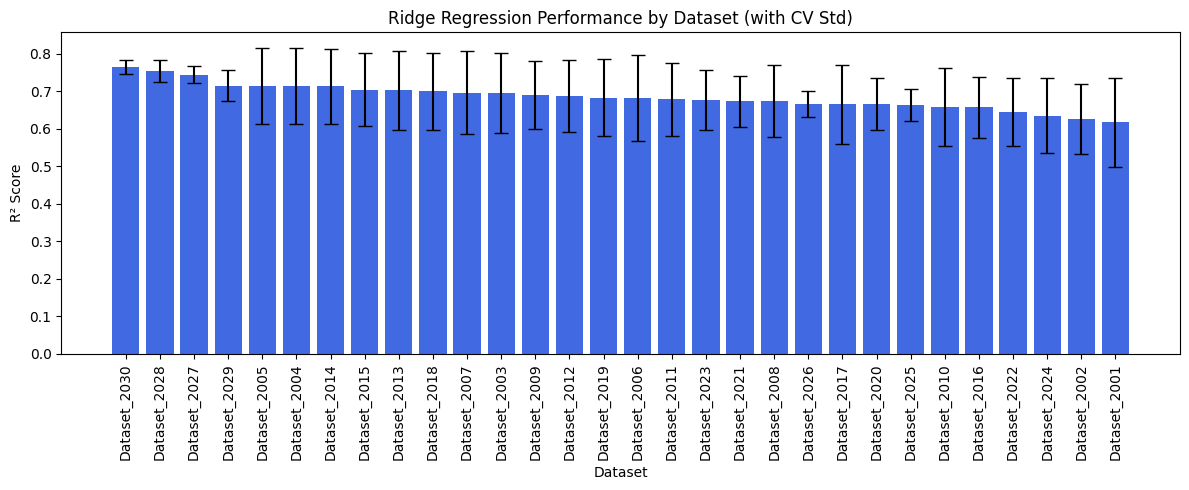


--- Ridge Coefficient Analysis Across All Models ---

Mean Absolute Coefficients Across All individual Datasets and Outer Folds (Ridge):
LogP               4.377947
MolRefractivity    1.272725
TPSA               1.041544
HBDonors           0.792875
MolWt              0.581082
HBAcceptors        0.560499
AromaticRings      0.532863
BranchingIndex     0.484421
RotatableBonds     0.322459
dtype: float64


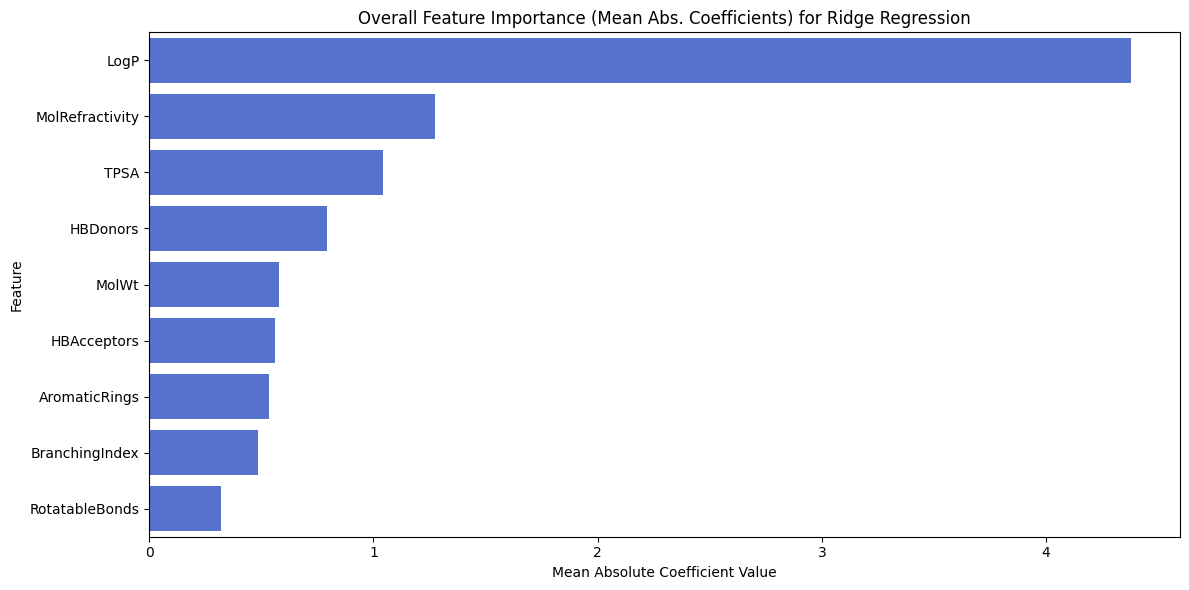

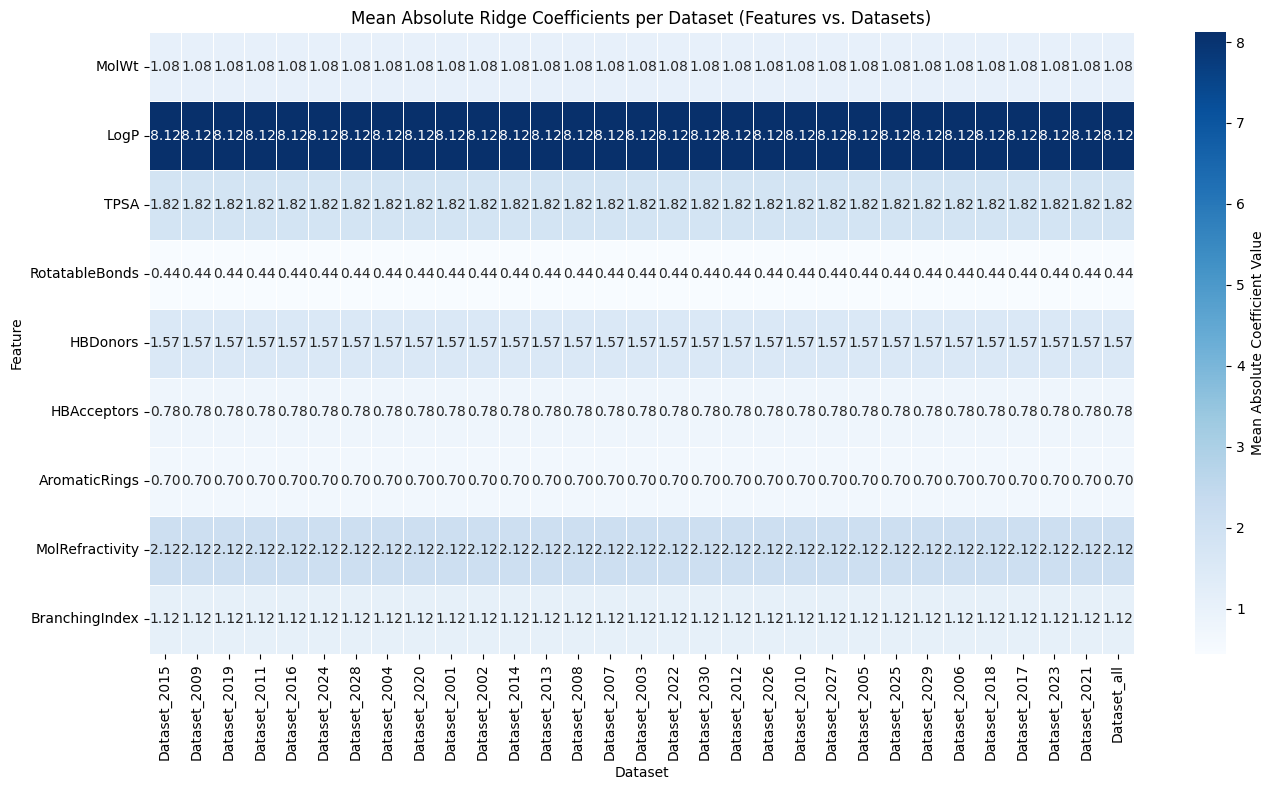

In [ ]:
ridge_results = []
all_ridge_coefficients = []

# Define features for the Regression
feature_names = [
    'MolWt', 'LogP', 'TPSA', 'RotatableBonds',
    'HBDonors', 'HBAcceptors', 'AromaticRings',
    'MolRefractivity', 'BranchingIndex'
]

# Scoring metrics dictionary
scoring = {
    'MAE': 'neg_mean_absolute_error',
    'MSE': 'neg_mean_squared_error',
    'R2': 'r2'
}


param_grid_ridge = {'ridge__alpha': np.logspace(-2, 2, 5)} #testing 0.01, 0.1, 1, 10, and 100
ridge_abs_coef_per_dataset = pd.DataFrame(index=feature_names)

print("\n-----------TRAINING RIDGE REGRESSION MODELS (NESTED CV)-------------")
# Loop through test_datasets
for dataset_name, data_split in split_datasets.items():
    print(f"Processing Test fold of {dataset_name}...")

    # Extract features (X) and target (y) for the current dataset
    X = data_split['X_train']
    y = data_split['y_train']

    # Create pipeline: scaling + Ridge regression
        # scaling features to have a mean of 0 and a std of 1
    model_pipeline = make_pipeline(StandardScaler(), Ridge(max_iter=10000, random_state=42))

    #Parameter tuning (inner cv)
    grid = GridSearchCV(model_pipeline, param_grid_ridge, cv=5, scoring='r2')

    # Perform nested cross-validation (outer cv)
    cv_results = cross_validate(grid, X, y, cv=5, scoring=scoring, return_estimator=True)

    for fold_grid_estimator in cv_results['estimator']: #loop iterates 5 times, once for every outer fold
        # In each iteration get the best Ridge model found by GridSearchCV within this specific outer fold
        best_ridge_in_fold = fold_grid_estimator.best_estimator_.named_steps['ridge']
        # Store the ridge coefficients of the best ridge model (after scaling so these are directly comparable)
        all_ridge_coefficients.append(best_ridge_in_fold.coef_)

    best_alpha_per_fold = [estimator.best_params_['ridge__alpha'] for estimator in cv_results['estimator']] #technically not necessary but interesting to check out

    # Getting a single 'best_alpha' per testfold of each dataset for training the final model (on whole training data fold), no nested CV
    grid.fit(X, y)
    best_alpha_for_reporting = grid.best_params_['ridge__alpha']

    ridge_results.append({
        'Dataset': dataset_name,
        'Model': 'Ridge',
        'Alpha': best_alpha_for_reporting,
        'MAE': -cv_results['test_MAE'].mean(),
        'MAE_std': cv_results['test_MAE'].std(),
        'MSE': -cv_results['test_MSE'].mean(),
        'MSE_std': cv_results['test_MSE'].std(),
        'R2': cv_results['test_R2'].mean(),
        'R2_std': cv_results['test_R2'].std()
})

# Convert to DataFrame
ridge_df = pd.DataFrame(ridge_results)
ridge_df = ridge_df.sort_values(by='R2', ascending=False).reset_index(drop=True)

# Show summary

print("\n--- Ridge Regression Performance Summary ---")
print(ridge_df)

# Plot R² comparison
plt.figure(figsize=(12, 5))
plt.bar(ridge_df['Dataset'], ridge_df['R2'], yerr=ridge_df['R2_std'], capsize=5, color='royalblue')
plt.ylabel('R² Score')
plt.xlabel('Dataset')
plt.title('Ridge Regression Performance by Dataset (with CV Std)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

print("\n--- Ridge Coefficient Analysis Across All Models ---")


all_ridge_coef_df = pd.DataFrame(all_ridge_coefficients, columns=feature_names)

mean_abs_coefficients = all_ridge_coef_df.abs().mean().sort_values(ascending=False)

print("\nMean Absolute Coefficients Across All individual Datasets and Outer Folds (Ridge):")
print(mean_abs_coefficients)

# Bar Chart of Mean Absolute Coefficients
plt.figure(figsize=(12, 6))
sns.barplot(x=mean_abs_coefficients.values, y=mean_abs_coefficients.index,color='royalblue', legend=False)
plt.xlabel('Mean Absolute Coefficient Value')
plt.ylabel('Feature')
plt.title('Overall Feature Importance (Mean Abs. Coefficients) for Ridge Regression')
plt.tight_layout()
plt.show()

start_index = 0
for dataset_name_temp, data_parts_temp in all_data.items():
    end_index = start_index + 5
    dataset_fold_coefficients = all_ridge_coefficients[start_index:end_index]

    if end_index <= len(all_ridge_coefficients):
      dataset_fold_coefficients = all_ridge_coefficients[start_index:end_index]

      #mean absolute coefficient for each feature for this dataset
      mean_abs_for_dataset = pd.DataFrame(dataset_fold_coefficients, columns=feature_names).abs().mean()

      ridge_abs_coef_per_dataset[dataset_name_temp] = mean_abs_for_dataset

plt.figure(figsize=(14, 8))
sns.heatmap(ridge_abs_coef_per_dataset, cmap='Blues', annot=True, fmt=".2f", linewidths=.5, cbar_kws={'label': 'Mean Absolute Coefficient Value'})
plt.title('Mean Absolute Ridge Coefficients per Dataset (Features vs. Datasets)')
plt.ylabel('Feature')
plt.xlabel('Dataset')
plt.tight_layout()
plt.show()

## **Lasso Regression**
Hyperparameter alpha tuning with GridSearchCV, R² as the scoring metric

5-fold nested cross-validation evaluation with the best alpha

standarization


-----------TRAINING LASSO REGRESSION MODELS (NESTED CV)-------------
Processing Test fold of Dataset_2015...
Processing Test fold of Dataset_2009...
Processing Test fold of Dataset_2019...
Processing Test fold of Dataset_2011...
Processing Test fold of Dataset_2016...
Processing Test fold of Dataset_2024...
Processing Test fold of Dataset_2028...
Processing Test fold of Dataset_2004...
Processing Test fold of Dataset_2020...
Processing Test fold of Dataset_2001...
Processing Test fold of Dataset_2002...
Processing Test fold of Dataset_2014...
Processing Test fold of Dataset_2013...
Processing Test fold of Dataset_2008...
Processing Test fold of Dataset_2007...
Processing Test fold of Dataset_2003...
Processing Test fold of Dataset_2022...
Processing Test fold of Dataset_2030...
Processing Test fold of Dataset_2012...
Processing Test fold of Dataset_2026...
Processing Test fold of Dataset_2010...
Processing Test fold of Dataset_2027...
Processing Test fold of Dataset_2005...
Processing

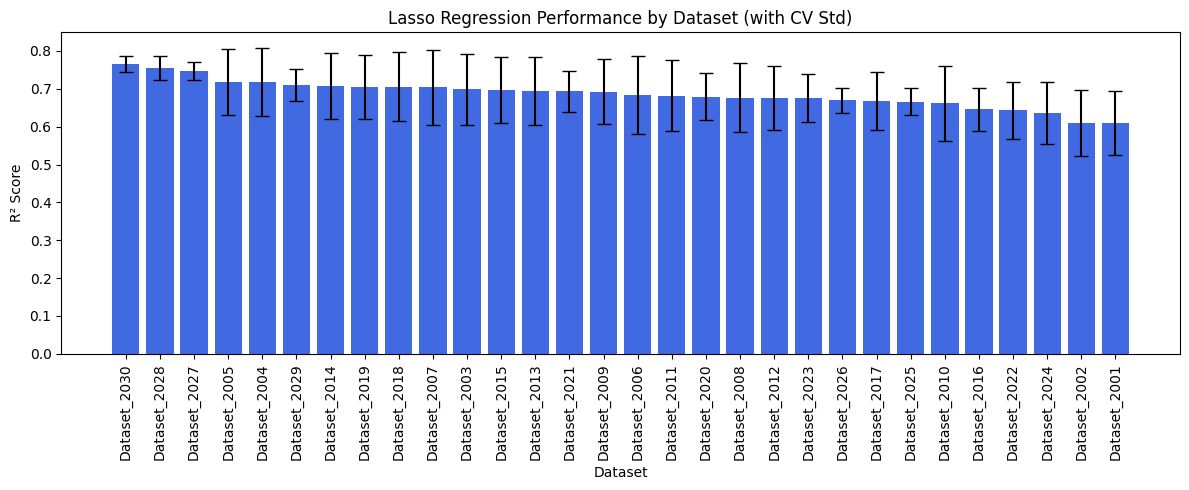


--- Lasso Zero Coefficient Analysis ---

Features most frequently set to zero by Lasso across all datasets and outer folds:
           Feature  Zero_Count  Zero_Frequency (%)
0            MolWt          98           63.225806
1             TPSA          91           58.709677
2   BranchingIndex          86           55.483871
3   RotatableBonds          62           40.000000
4         HBDonors          42           27.096774
5      HBAcceptors          40           25.806452
6  MolRefractivity          29           18.709677
7    AromaticRings          21           13.548387
8             LogP           0            0.000000


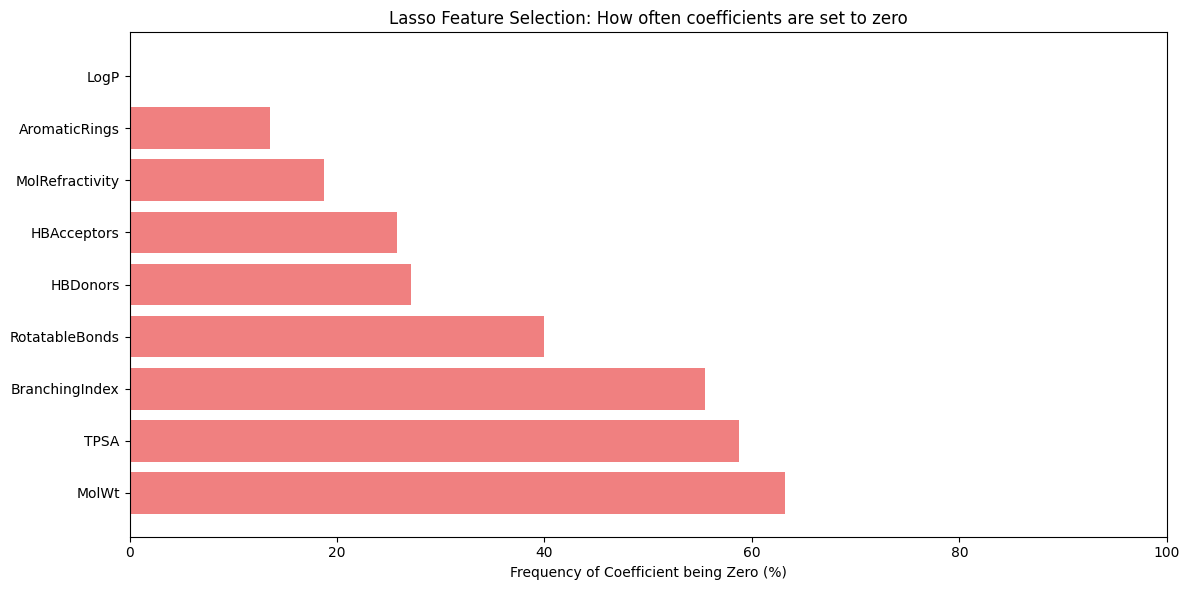

In [ ]:
lasso_results = []
all_lasso_coefficients = []

# Define Feature-Names
feature_names = [
    'MolWt', 'LogP', 'TPSA', 'RotatableBonds',
    'HBDonors', 'HBAcceptors', 'AromaticRings',
    'MolRefractivity', 'BranchingIndex'
]

zero_coefficient_counts_per_dataset = {feature: [] for feature in feature_names}

# Scoring-Metrics for Cross-Validation
scoring = {
    'MAE': 'neg_mean_absolute_error',
    'MSE': 'neg_mean_squared_error',
    'R2': 'r2'
}

# Possible alpha parameters for feature tuning per dataset
param_grid = {'lasso__alpha':  np.logspace(-2, 2, 5)}
zero_coefficient_counts_per_dataset = {feature: [] for feature in feature_names}

print("\n-----------TRAINING LASSO REGRESSION MODELS (NESTED CV)-------------")
# Loop through datasets
for dataset_name, data_split in split_datasets.items():
    print(f"Processing Test fold of {dataset_name}...")

    # Extract features (X) and target (y) for the current dataset
    X = data_split['X_train']
    y = data_split['y_train']

    # Pipeline: StandardScaler + Lasso
    model = make_pipeline(StandardScaler(), Lasso(max_iter=10000,random_state=42))

    #Parameter tuning (inner cv)
    grid = GridSearchCV(model, param_grid, cv=5, scoring='r2')

    #nested Cross Validation (outer cv)
    cv_results = cross_validate(grid, X, y, cv=5, scoring=scoring, return_estimator=True)


    #For interpretation: count how often a feature was set to zero
    current_dataset_zero_counts = {feature: 0 for feature in feature_names}
    tolerance = 1e-6 # tolerance for zero coefficients

    # Iterate through the fitted GridSearchCV estimators from each outer fold
    for fold_grid_estimator in cv_results['estimator']:
        # Get the best Lasso model for this specific outer fold
        best_lasso_in_fold = fold_grid_estimator.best_estimator_.named_steps['lasso']

        # Get its coefficients
        coefficients = best_lasso_in_fold.coef_

        # Count how many are close to zero
        for i, coef in enumerate(coefficients):
            if np.abs(coef) < tolerance:
                current_dataset_zero_counts[feature_names[i]] += 1

    # Store the counts for this dataset
    for feature in feature_names:
        zero_coefficient_counts_per_dataset[feature].append(current_dataset_zero_counts[feature])

    #Fit the GridSearchCV to the whole training_dataset to access the best model and parameters for reporting
    grid.fit(X, y)
    best_alpha = grid.best_params_['lasso__alpha']

    # Store results
    lasso_results.append({
        'Dataset': dataset_name,
        'Model': 'Lasso',
        'Alpha': best_alpha,
        'MAE': -cv_results['test_MAE'].mean(), # minus damit MAE für plot wieder richtig interpretierbar wird
        'MAE_std': cv_results['test_MAE'].std(),
        'MSE': -cv_results['test_MSE'].mean(), # minus damit MSE wieder pos wird
        'MSE_std': cv_results['test_MSE'].std(),
        'R2': cv_results['test_R2'].mean(),
        'R2_std': cv_results['test_R2'].std()
    })

# Convert to DataFrame
lasso_df = pd.DataFrame(lasso_results)
lasso_df = lasso_df.sort_values(by='R2', ascending=False).reset_index(drop=True)

# Show summary
print("\n--- Lasso Regression Performance Summary ---")
print(lasso_df)

# Plot R² comparison
plt.figure(figsize=(12, 5))
plt.bar(lasso_df['Dataset'], lasso_df['R2'], yerr=lasso_df['R2_std'], capsize=5, color='royalblue')
plt.ylabel('R² Score')
plt.xlabel('Dataset')
plt.title('Lasso Regression Performance by Dataset (with CV Std)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

print("\n--- Lasso Zero Coefficient Analysis ---")
# Calculate total zero counts for each feature across all outer folds and all datasets
total_zero_counts = {feature: 0 for feature in feature_names}
for feature in feature_names:
    total_zero_counts[feature] = sum(zero_coefficient_counts_per_dataset[feature])

# Calculate total number and percentage zero counts

num_datasets = len(all_data)
total_outer_folds = num_datasets * 5 # tot number of folds
zero_freq_df = pd.DataFrame({
    'Feature': feature_names,
    'Zero_Count': [total_zero_counts[f] for f in feature_names]
})
zero_freq_df['Zero_Frequency (%)'] = (zero_freq_df['Zero_Count'] / total_outer_folds) * 100 #percentages
zero_freq_df = zero_freq_df.sort_values(by='Zero_Frequency (%)', ascending=False).reset_index(drop=True)

print("\nFeatures most frequently set to zero by Lasso across all datasets and outer folds:")
print(zero_freq_df)

#Plot the zero frequency
plt.figure(figsize=(12, 6))
plt.barh(zero_freq_df['Feature'], zero_freq_df['Zero_Frequency (%)'], color='lightcoral')
plt.xlabel('Frequency of Coefficient being Zero (%)')
plt.title('Lasso Feature Selection: How often coefficients are set to zero')
plt.xlim(0, 100)
plt.tight_layout()
plt.show()


=> Again LogP is single most important descriptor

## **Random Forest**
Achtung hat bei mir ca 20 min gedauert um zu laufen

Processing Test fold of Dataset_2015...
Processing Test fold of Dataset_2009...
Processing Test fold of Dataset_2019...
Processing Test fold of Dataset_2011...
Processing Test fold of Dataset_2016...
Processing Test fold of Dataset_2024...
Processing Test fold of Dataset_2028...
Processing Test fold of Dataset_2004...
Processing Test fold of Dataset_2020...
Processing Test fold of Dataset_2001...
Processing Test fold of Dataset_2002...
Processing Test fold of Dataset_2014...
Processing Test fold of Dataset_2013...
Processing Test fold of Dataset_2008...
Processing Test fold of Dataset_2007...
Processing Test fold of Dataset_2003...
Processing Test fold of Dataset_2022...
Processing Test fold of Dataset_2030...
Processing Test fold of Dataset_2012...
Processing Test fold of Dataset_2026...
Processing Test fold of Dataset_2010...
Processing Test fold of Dataset_2027...
Processing Test fold of Dataset_2005...
Processing Test fold of Dataset_2025...
Processing Test fold of Dataset_2029...


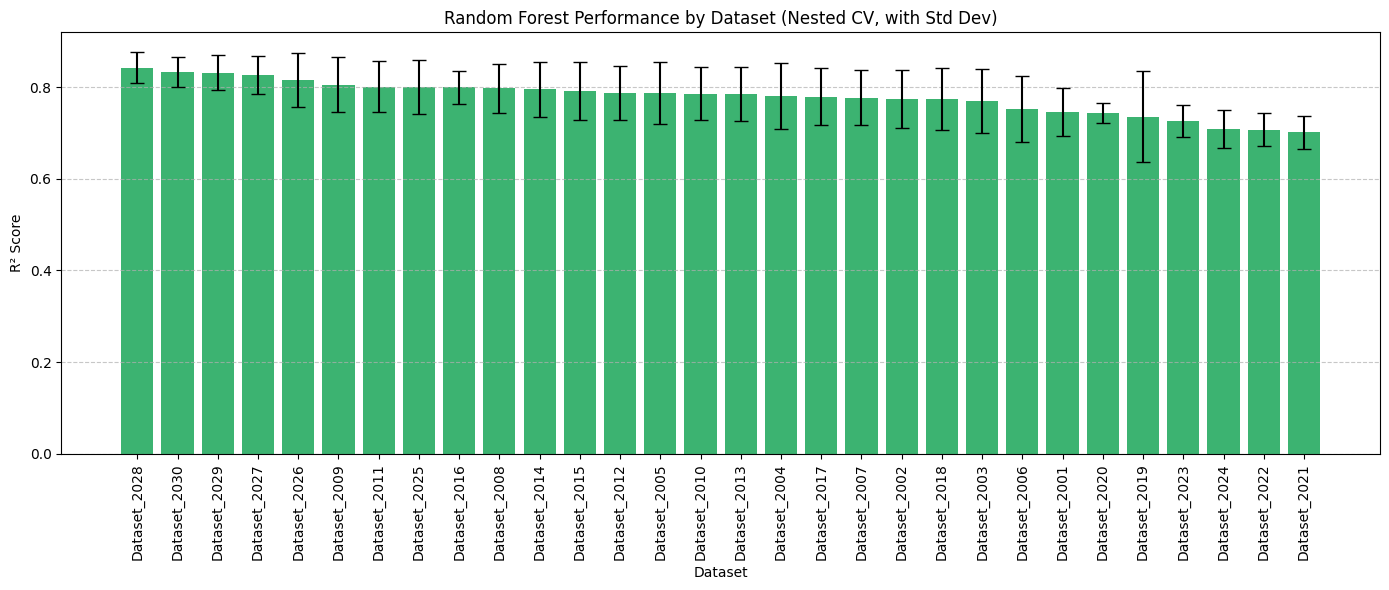


--- Random Forest Feature Importance Analysis Across All Models ---

Mean Feature Importances Across All Datasets and Outer Folds (Random Forest):
LogP               0.701749
MolWt              0.092322
MolRefractivity    0.050388
TPSA               0.040577
RotatableBonds     0.036052
BranchingIndex     0.031352
HBDonors           0.019092
HBAcceptors        0.017944
AromaticRings      0.010524
dtype: float64


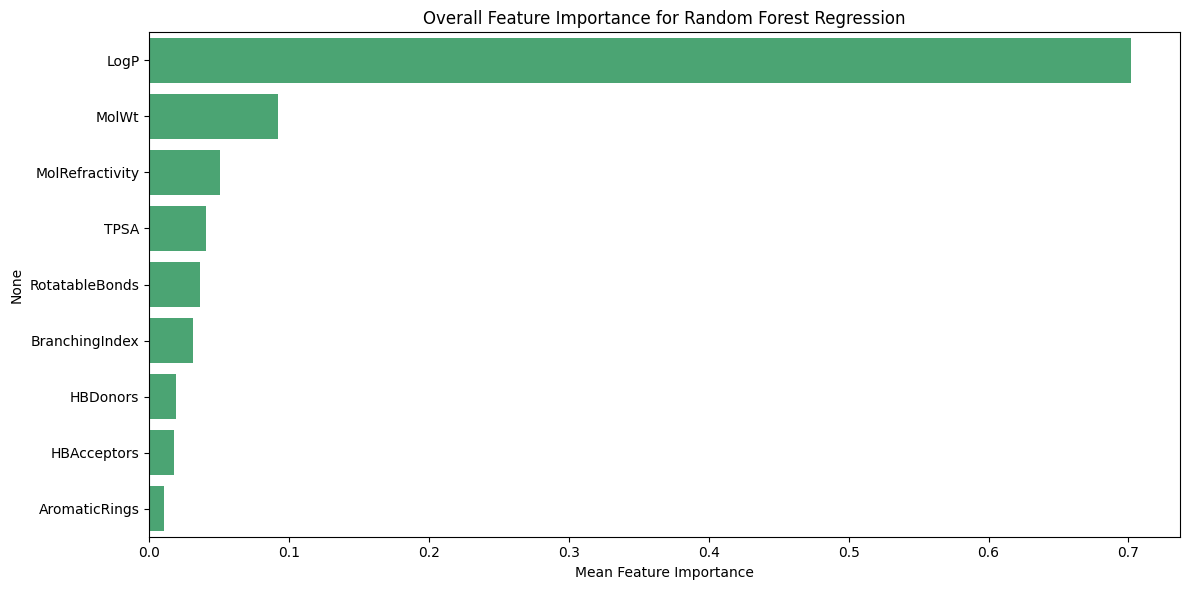

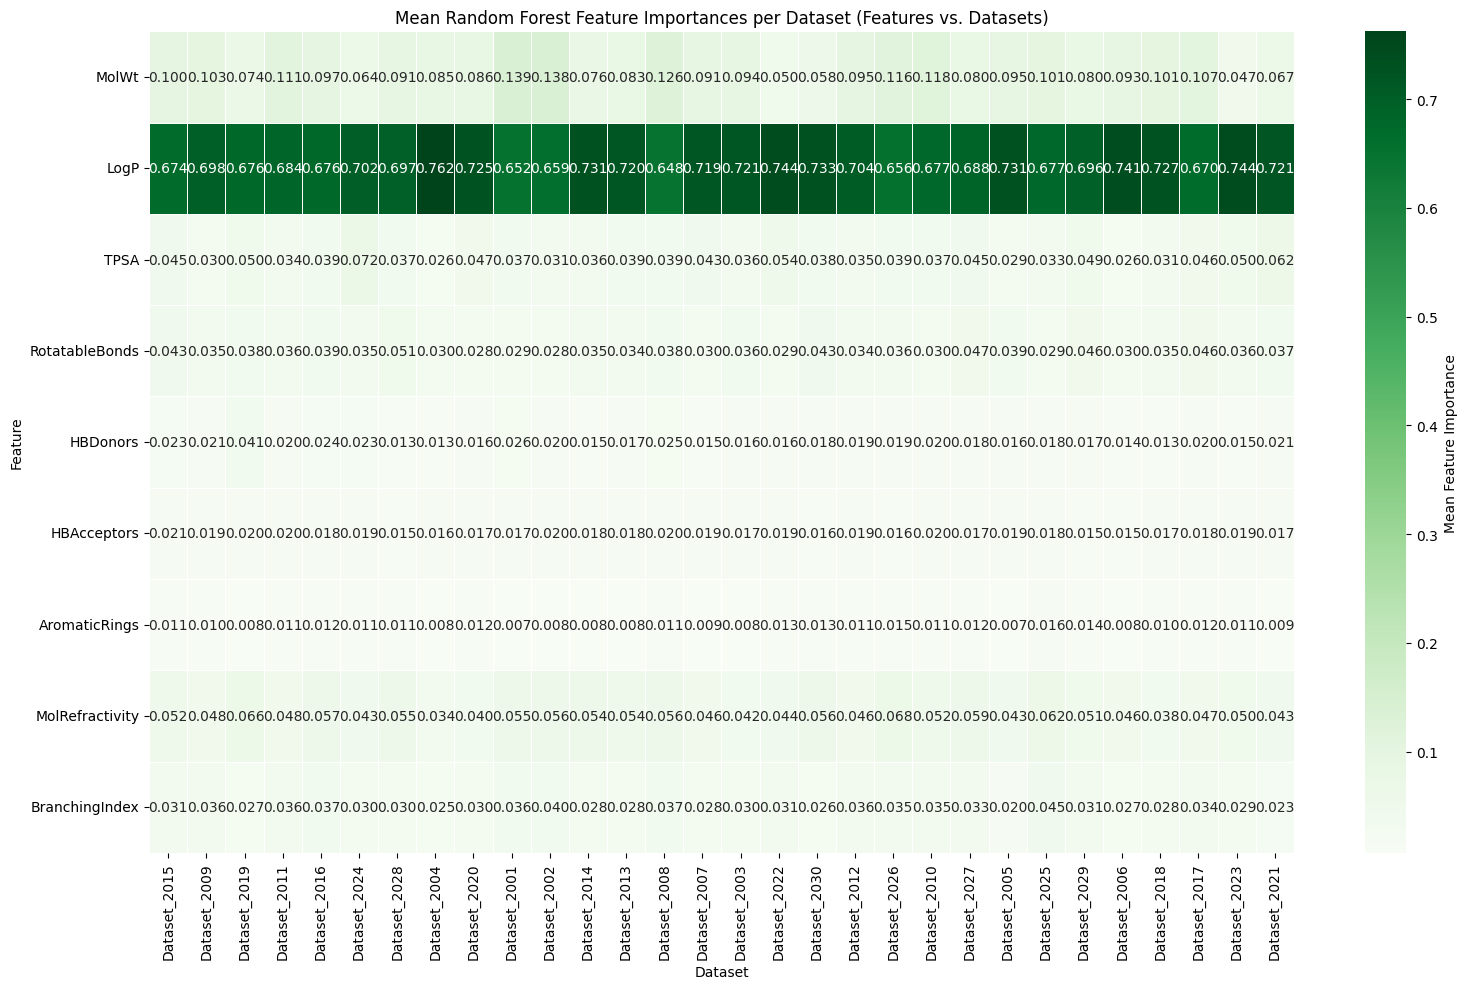

In [ ]:
feature_names = [
    'MolWt', 'LogP', 'TPSA', 'RotatableBonds',
    'HBDonors', 'HBAcceptors', 'AromaticRings',
    'MolRefractivity', 'BranchingIndex'
]

rf_results = []
all_rf_feature_importances = []

scoring_rf = {
    'MAE': 'neg_mean_absolute_error',
    'MSE': 'neg_mean_squared_error',
    'R2': 'r2'
}

# Define hyperparameter grid for Random Forest (tuned for faster execution with fewer options)
param_grid_rf = {
    'n_estimators': [50, 100],  # Number of trees in the forest
    'max_features': [0.6, 1.0], # The number of features to consider when looking for the best split
    'min_samples_leaf': [1, 5]  # The minimum number of samples required to be at a leaf node
}

rf_feature_importance_per_dataset = pd.DataFrame(index=feature_names)


# Loop through all datasets
for dataset_name, data_split in split_datasets.items():
    print(f"Processing Test fold of {dataset_name}...")

    # Extract features (X) and target (y) for the current dataset
    X = data_split['X_train']
    y = data_split['y_train']

    # Create the base Random Forest Regressor model
    base_rf_model = RandomForestRegressor(random_state=42)

    # Setup GridSearchCV for hyperparameter tuning (inner CV)
    grid_search_rf = GridSearchCV(base_rf_model,param_grid_rf,cv=5,scoring='r2',n_jobs=-1 )

    # Perform nested cross-validation (outer CV)
    cv_results = cross_validate(grid_search_rf,X, y,cv=5,scoring=scoring_rf,return_estimator=True)

    # Collect feature importances from each outer fold's best estimator
    current_dataset_importances = []
    for fold_grid_estimator in cv_results['estimator']:
        # fold_grid_estimator is the GridSearchCV object for this outer fold
        # Its best_estimator_ is the RandomForestRegressor with tuned params
        best_rf_model_in_fold = fold_grid_estimator.best_estimator_
        current_dataset_importances.append(best_rf_model_in_fold.feature_importances_)

    # Store these for overall feature importance analysis later
    all_rf_feature_importances.extend(current_dataset_importances)

    # Calculate mean feature importances for this specific dataset to be used in the heatmap
    mean_importances_for_dataset = pd.DataFrame(current_dataset_importances, columns=feature_names).mean()
    rf_feature_importance_per_dataset[dataset_name] = mean_importances_for_dataset


    # For reporting the 'best_params' for the dataset as a whole,
    # fit GridSearchCV one more time on the full dataset (X, y) after the CV loop.
    # This is distinct from the models used for nested CV performance evaluation.
    grid_search_rf.fit(X, y)
    best_params_for_reporting = grid_search_rf.best_params_


    # Store the results with mean and std from nested CV
    rf_results.append({
        'Dataset': dataset_name,
        'Model': 'RandomForest',
        'Best_N_Estimators': best_params_for_reporting.get('n_estimators'),
        'Best_Max_Features': best_params_for_reporting.get('max_features'),
        'Best_Min_Samples_Leaf': best_params_for_reporting.get('min_samples_leaf'),
        'MAE': -cv_results['test_MAE'].mean(),
        'MAE_std': cv_results['test_MAE'].std(),
        'MSE': -cv_results['test_MSE'].mean(),
        'MSE_std': cv_results['test_MSE'].std(),
        'R2': cv_results['test_R2'].mean(),
        'R2_std': cv_results['test_R2'].std()
    })
# Convert to DataFrame
rf_results_df = pd.DataFrame(rf_results)

# Sort by performance
rf_results_df = rf_results_df.sort_values(by='R2', ascending=False).reset_index(drop=True)

# Display the summary table
print("\n--- Random Forest Model Performance Summary (Nested CV) ---")
print(rf_results_df)

# Plot R² for all datasets with standard deviation
plt.figure(figsize=(14, 6))
plt.bar(rf_results_df['Dataset'], rf_results_df['R2'], yerr=rf_results_df['R2_std'], capsize=5, color='mediumseagreen')
plt.ylabel('R² Score')
plt.xlabel('Dataset')
plt.title('Random Forest Performance by Dataset (Nested CV, with Std Dev)')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# --- Random Forest Feature Importance Analysis ---
print("\n--- Random Forest Feature Importance Analysis Across All Models ---")

# Convert the list of feature importance arrays into a DataFrame
# Each row is a set of importances from one outer fold's best RF model
all_rf_importances_df = pd.DataFrame(all_rf_feature_importances, columns=feature_names)

# Calculate the mean feature importance for each feature across all models/folds
mean_rf_importances = all_rf_importances_df.mean().sort_values(ascending=False)

print("\nMean Feature Importances Across All Datasets and Outer Folds (Random Forest):")
print(mean_rf_importances)

# Bar Chart of Mean Feature Importances
plt.figure(figsize=(12, 6))
sns.barplot(x=mean_rf_importances.values, y=mean_rf_importances.index, color='mediumseagreen', legend=False)
plt.xlabel('Mean Feature Importance')
plt.title('Overall Feature Importance for Random Forest Regression')
plt.tight_layout()
plt.show()

# Heatmap of Mean Feature Importance per Dataset
plt.figure(figsize=(16, 10))
sns.heatmap(rf_feature_importance_per_dataset, cmap='Greens', annot=True, fmt=".3f", linewidths=.5, cbar_kws={'label': 'Mean Feature Importance'})
plt.title('Mean Random Forest Feature Importances per Dataset (Features vs. Datasets)')
plt.ylabel('Feature')
plt.xlabel('Dataset')
plt.tight_layout()
plt.show()


## **Ridge regression on entire Dataset**

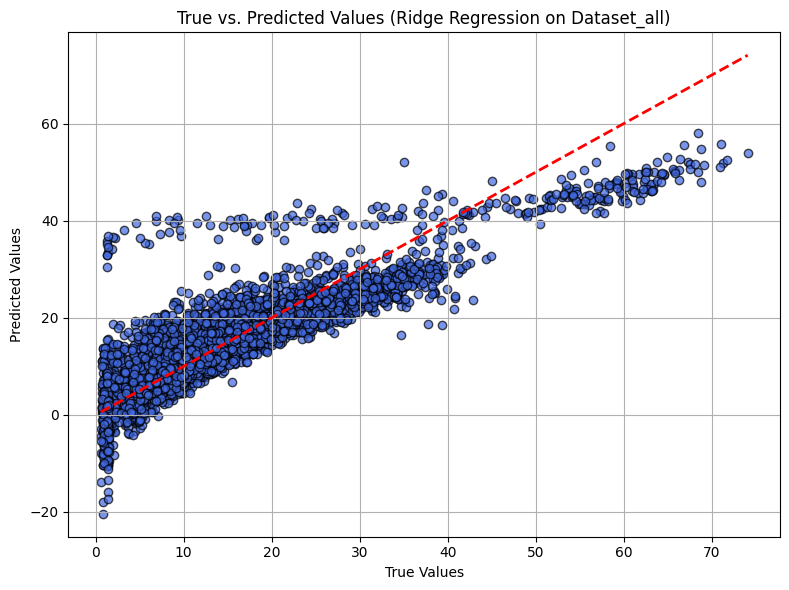


--- Ridge Regression Performance Summary ---
Best Alpha: 1.0
MAE: 3.1515 ± 0.1215
MSE: 22.6167 ± 2.2658
R2: 0.7736 ± 0.0112


/tmp/ipython-input-13-1941183171.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette='Blues')


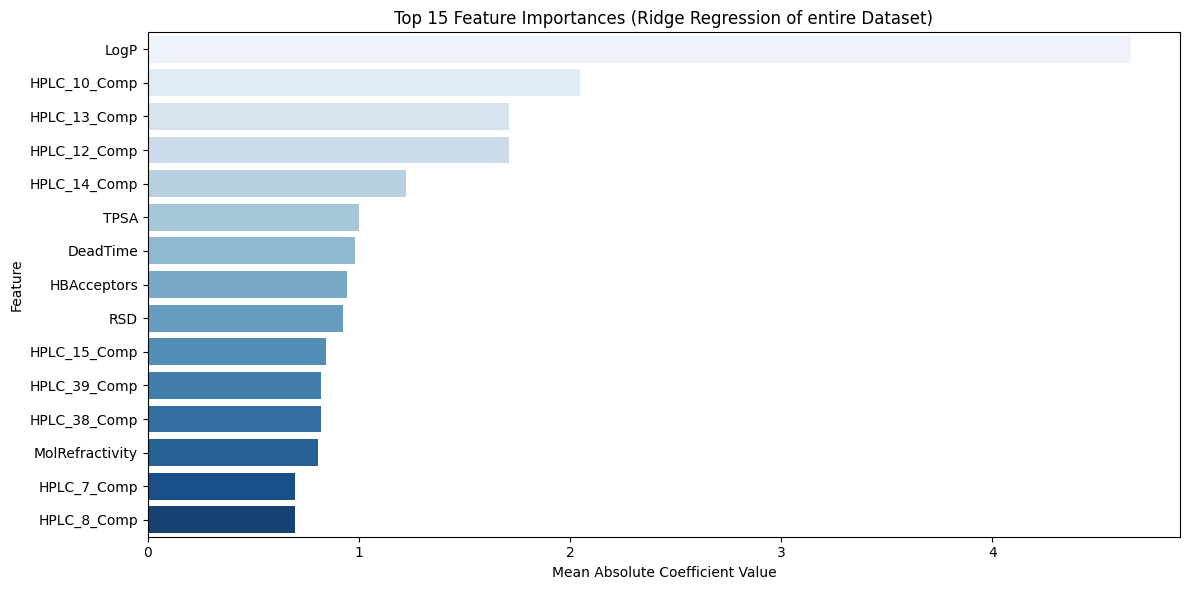

In [ ]:
ridge_results_dataset_all = []
# --- Load and prepare dataset ---
dataset_name = 'Dataset_all'
df = all_data[dataset_name]['combined_df'].dropna().copy()
feature_names = feature_names_dataset_all

# Prepare input and target
X = split_dataset_all['Dataset_all']["X_train_dataset_all"]
y = split_dataset_all['Dataset_all']["y_train_dataset_all"]

# --- Define Ridge model and nested cross-validation ---
scoring = {
    'MAE': 'neg_mean_absolute_error',
    'MSE': 'neg_mean_squared_error',
    'R2': 'r2'
}
param_grid = {'ridge__alpha': np.logspace(-2, 2, 5)}
pipeline = make_pipeline(StandardScaler(), Ridge(max_iter=10000, random_state=42))

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2')
cv_results = cross_validate(grid_search, X, y, cv=5, scoring=scoring, return_estimator=True)

# --- Collect and summarize results ---
coefs = [est.best_estimator_.named_steps['ridge'].coef_ for est in cv_results['estimator']]
coef_df = pd.DataFrame(coefs, columns=feature_names)
mean_abs_coef = coef_df.abs().mean().sort_values(ascending=False) # mean coefficients of folds

# Train on full data to get final alpha
grid_search.fit(X, y)
best_alpha = grid_search.best_params_['ridge__alpha']

ridge_results_dataset_all.append({
    'Dataset': dataset_name,
    'Model': 'Ridge',
    'Alpha': best_alpha,
    'MAE': -cv_results['test_MAE'].mean(),
    'MAE_std': cv_results['test_MAE'].std(),
    'MSE': -cv_results['test_MSE'].mean(),
    'MSE_std': cv_results['test_MSE'].std(),
    'R2': cv_results['test_R2'].mean(),
    'R2_std': cv_results['test_R2'].std()
})

best_model = grid_search.best_estimator_
y_pred_ridge_y_train_dataset_all = best_model.predict(X)

# Plot true vs predicted
plt.figure(figsize=(8, 6))
plt.scatter(y, y_pred_ridge_y_train_dataset_all, alpha=0.7, color='royalblue', edgecolor='k')
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--r', linewidth=2)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs. Predicted Values (Ridge Regression on Dataset_all)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Print performance
print("\n--- Ridge Regression Performance Summary ---")
print(f"Best Alpha: {best_alpha}")
print(f"MAE: {-cv_results['test_MAE'].mean():.4f} ± {cv_results['test_MAE'].std():.4f}")
print(f"MSE: {-cv_results['test_MSE'].mean():.4f} ± {cv_results['test_MSE'].std():.4f}")
print(f"R2: {cv_results['test_R2'].mean():.4f} ± {cv_results['test_R2'].std():.4f}")

# --- Plot top features ---
top_n = 15  # Adjust number of top features shown
top_features = mean_abs_coef.head(top_n)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_features.values, y=top_features.index, palette='Blues')
plt.xlabel('Mean Absolute Coefficient Value')
plt.ylabel('Feature')
plt.title(f'Top {top_n} Feature Importances (Ridge Regression of entire Dataset)')
plt.tight_layout()
plt.show()


## **Lasso regression on entire Dataset**


----------- TRAINING LASSO REGRESSION MODEL FOR 'Dataset_all' -------------

--- Lasso Regression Performance Summary ---
       Dataset  Model  Alpha     MAE   MAE_std      MSE   MSE_std        R2  \
0  Dataset_all  Lasso   0.01  3.1481  0.120172  22.6289  2.259907  0.773525   

    R2_std  
0  0.01101  


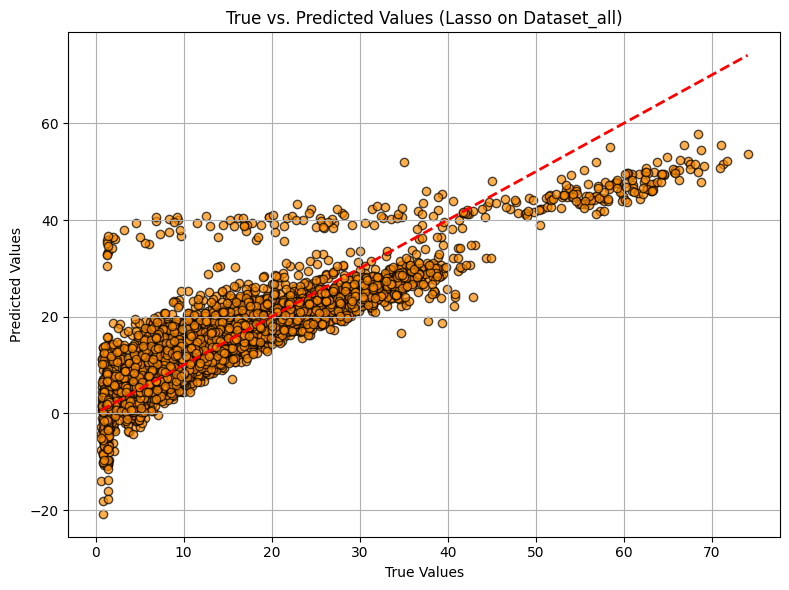


--- Zero Coefficient Frequency (Dataset_all) ---
            Feature  Zero_Count  Zero_Frequency (%)
0      HPLC_45_Comp           5               100.0
1      HPLC_59_Comp           5               100.0
2      HPLC_54_Comp           5               100.0
3      HPLC_55_Rate           5               100.0
4      HPLC_55_Comp           5               100.0
..              ...         ...                 ...
230    HPLC_12_Comp           0                 0.0
231    HPLC_15_Comp           0                 0.0
232    HPLC_21_Comp           0                 0.0
233    HPLC_38_Comp           0                 0.0
234  BranchingIndex           0                 0.0

[235 rows x 3 columns]


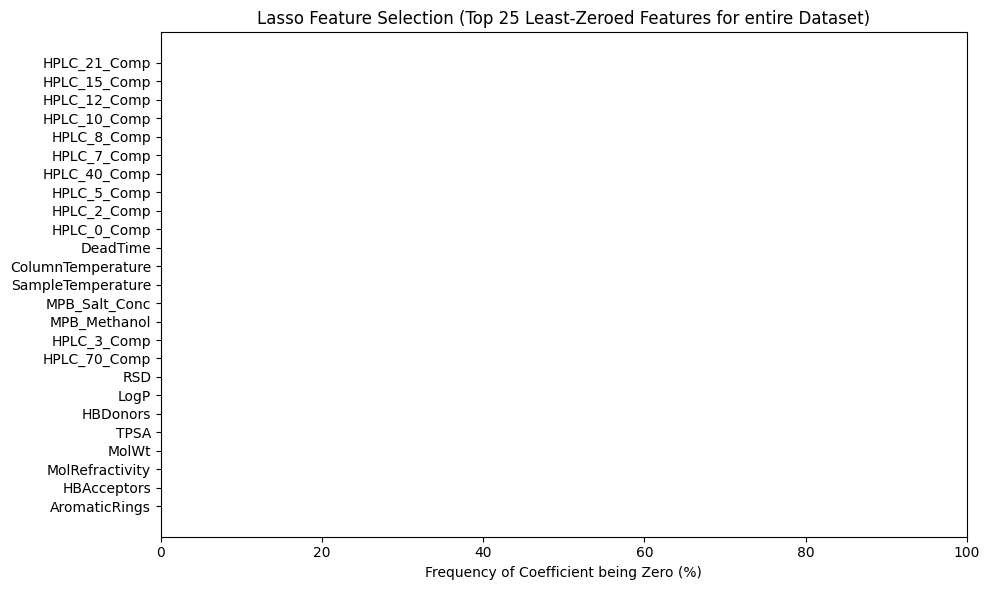

In [ ]:
lasso_results_dataset_all = []
all_lasso_coefficients_dataset_all = []

# Define Feature Names
feature_names = feature_names_dataset_all

zero_coefficient_counts = {feature: 0 for feature in feature_names}

# Scoring metrics
scoring = {
    'MAE': 'neg_mean_absolute_error',
    'MSE': 'neg_mean_squared_error',
    'R2': 'r2'
}

# Lasso alpha parameter grid
param_grid = {'lasso__alpha': np.logspace(-2, 2, 5)}

print("\n----------- TRAINING LASSO REGRESSION MODEL FOR 'Dataset_all' -------------")

# Load data
dataset_name = 'Dataset_all'
X = split_dataset_all[dataset_name]["X_train_dataset_all"]
y = split_dataset_all[dataset_name]["y_train_dataset_all"]

# Pipeline
model = make_pipeline(StandardScaler(), Lasso(max_iter=10000, random_state=42))

# Grid search (inner CV)
grid = GridSearchCV(model, param_grid, cv=5, scoring='r2')

# Nested cross-validation (outer CV)
cv_results = cross_validate(grid, X, y, cv=5, scoring=scoring, return_estimator=True)

# Count zero coefficients across outer folds
tolerance = 1e-6
for fold_grid_estimator in cv_results['estimator']:
    best_lasso = fold_grid_estimator.best_estimator_.named_steps['lasso']
    coefs = best_lasso.coef_
    for i, coef in enumerate(coefs):
        if np.abs(coef) < tolerance:
            zero_coefficient_counts[feature_names[i]] += 1

# Fit full training data
grid.fit(X, y)
best_alpha = grid.best_params_['lasso__alpha']

# Store results
lasso_results_dataset_all.append({
    'Dataset': dataset_name,
    'Model': 'Lasso',
    'Alpha': best_alpha,
    'MAE': -cv_results['test_MAE'].mean(),
    'MAE_std': cv_results['test_MAE'].std(),
    'MSE': -cv_results['test_MSE'].mean(),
    'MSE_std': cv_results['test_MSE'].std(),
    'R2': cv_results['test_R2'].mean(),
    'R2_std': cv_results['test_R2'].std()
})

# Results summary
lasso_df_dataset_all = pd.DataFrame(lasso_results_dataset_all)
print("\n--- Lasso Regression Performance Summary ---")
print(lasso_df_dataset_all)

# --- Predict using the final model trained on all training data ---
final_model = grid.best_estimator_
y_pred_lasso_y_train_dataset_all = final_model.predict(X)

# --- Plot True vs. Predicted Values ---
plt.figure(figsize=(8, 6))
plt.scatter(y, y_pred_lasso_y_train_dataset_all, alpha=0.7, color='darkorange', edgecolor='k')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', linewidth=2)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs. Predicted Values (Lasso on Dataset_all)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Zero coefficient analysis
zero_freq_df = pd.DataFrame({
    'Feature': feature_names,
    'Zero_Count': [zero_coefficient_counts[f] for f in feature_names]
})
zero_freq_df['Zero_Frequency (%)'] = (zero_freq_df['Zero_Count'] / 5) * 100  # 5 outer folds
zero_freq_df = zero_freq_df.sort_values(by='Zero_Frequency (%)', ascending=False).reset_index(drop=True)

print("\n--- Zero Coefficient Frequency (Dataset_all) ---")
print(zero_freq_df)

# Limit to top features least often set to zero
X_top = 25  # adjust as needed
zero_freq_df = zero_freq_df.nsmallest(X_top, 'Zero_Frequency (%)')

# Plot
plt.figure(figsize=(10, 6))
plt.barh(zero_freq_df['Feature'], zero_freq_df['Zero_Frequency (%)'], color='lightcoral')
plt.xlabel('Frequency of Coefficient being Zero (%)')
plt.title(f'Lasso Feature Selection (Top {X_top} Least-Zeroed Features for entire Dataset)')
plt.xlim(0, 100)
plt.tight_layout()
plt.show()

## **Random Forest on entire Dataset**
Took over 40 minutes to run...


--- Random Forest Performance Summary (Dataset_all) ---
       Dataset         Model  Best_N_Estimators  Best_Max_Features  \
0  Dataset_all  RandomForest                100                0.6   

   Best_Min_Samples_Leaf      MAE   MAE_std       MSE   MSE_std       R2  \
0                      1  1.14503  0.041413  4.239062  0.626608  0.95732   

   R2_std  
0  0.0066  


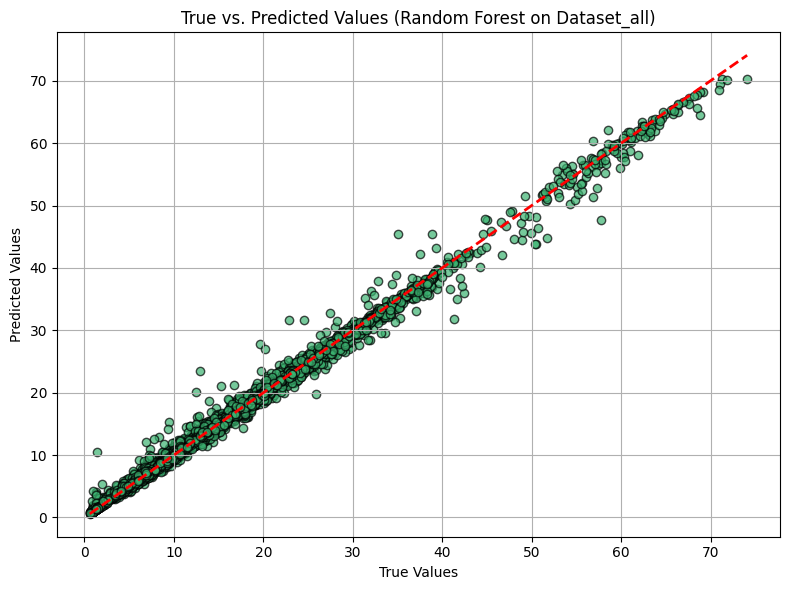


--- Feature Importance Analysis (Dataset_all) ---
LogP               0.287083
HPLC_41_Comp       0.052774
RSD                0.052436
HPLC_40_Comp       0.051989
HPLC_4_Comp        0.033239
                     ...   
MPA_ACN            0.000000
MPA_Water          0.000000
MPA_Ratio_ACN      0.000000
MPB_Ratio_Water    0.000000
MPB_Water          0.000000
Length: 235, dtype: float64


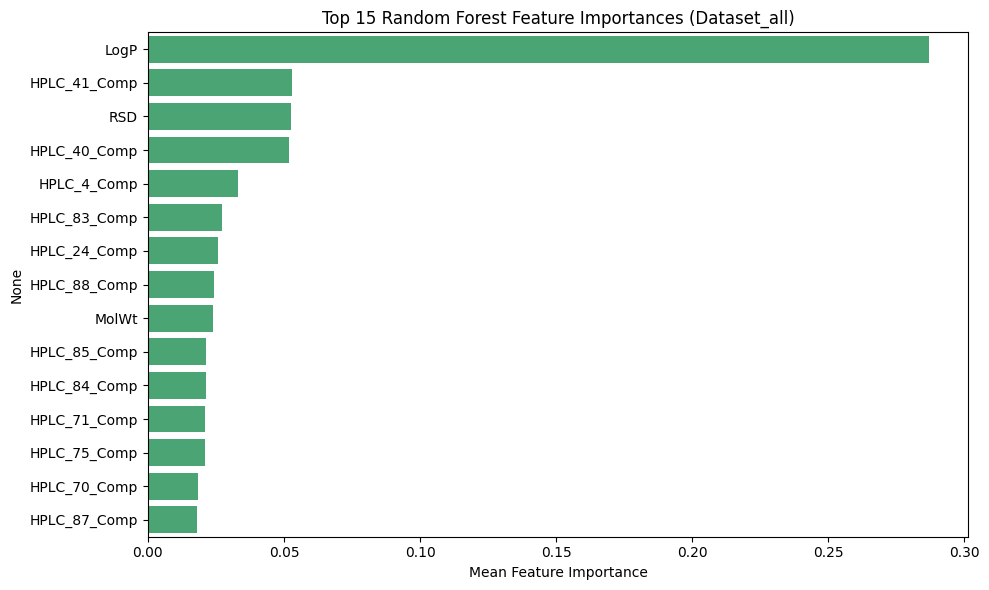

In [ ]:
rf_results_dataset_all = []
feature_names = feature_names_dataset_all

scoring_rf = {
    'MAE': 'neg_mean_absolute_error',
    'MSE': 'neg_mean_squared_error',
    'R2': 'r2'
}

param_grid_rf = {
    'n_estimators': [50, 100],
    'max_features': [0.6, 1.0],
    'min_samples_leaf': [1, 5]
}

# --- Data Preparation ---
dataset_name = 'Dataset_all'
X = split_dataset_all[dataset_name]["X_train_dataset_all"]
y = split_dataset_all[dataset_name]["y_train_dataset_all"]

# --- Model Setup ---
base_rf_model = RandomForestRegressor(random_state=42)
grid_search_rf = GridSearchCV(base_rf_model, param_grid_rf, cv=5, scoring='r2', n_jobs=-1)

# --- Nested Cross-Validation ---
cv_results = cross_validate(grid_search_rf, X, y, cv=5, scoring=scoring_rf, return_estimator=True)

# --- Feature Importances Collection ---
rf_feature_importances = []
for fold_estimator in cv_results['estimator']:
    best_rf_model = fold_estimator.best_estimator_
    rf_feature_importances.append(best_rf_model.feature_importances_)

# --- Final Fit on Full Training Set ---
grid_search_rf.fit(X, y)
best_params = grid_search_rf.best_params_

# --- Results Storage ---
rf_results_dataset_all = [{
    'Dataset': dataset_name,
    'Model': 'RandomForest',
    'Best_N_Estimators': best_params['n_estimators'],
    'Best_Max_Features': best_params['max_features'],
    'Best_Min_Samples_Leaf': best_params['min_samples_leaf'],
    'MAE': -cv_results['test_MAE'].mean(),
    'MAE_std': cv_results['test_MAE'].std(),
    'MSE': -cv_results['test_MSE'].mean(),
    'MSE_std': cv_results['test_MSE'].std(),
    'R2': cv_results['test_R2'].mean(),
    'R2_std': cv_results['test_R2'].std()
}]

rf_results_df_dataset_all = pd.DataFrame(rf_results_dataset_all)

# --- Performance Summary ---
print("\n--- Random Forest Performance Summary (Dataset_all) ---")
print(rf_results_df_dataset_all)

# --- Plot True vs. Predicted Values on Training Data ---
best_rf_model = grid_search_rf.best_estimator_
y_pred_rf_y_train_dataset_all = best_rf_model.predict(X)

plt.figure(figsize=(8, 6))
plt.scatter(y, y_pred_rf_y_train_dataset_all, alpha=0.7, color='mediumseagreen', edgecolor='k')
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--r', linewidth=2)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs. Predicted Values (Random Forest on Dataset_all)")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Feature Importance Analysis ---
print("\n--- Feature Importance Analysis (Dataset_all) ---")
rf_importance_df = pd.DataFrame(rf_feature_importances, columns=feature_names)
mean_rf_importances = rf_importance_df.mean().sort_values(ascending=False)

print(mean_rf_importances)

# --- Limit to Top N Features ---
top_n = 15  # Adjust this number to show more/less
top_features = mean_rf_importances.head(top_n)

# --- Plot Top N Feature Importances ---
plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index, color='mediumseagreen')
plt.xlabel('Mean Feature Importance')
plt.title(f'Top {top_n} Random Forest Feature Importances (Dataset_all)')
plt.tight_layout()
plt.show()


## Combining results from the individual models with the ones from dataset_all

In [ ]:
ridge_results.extend(ridge_results_dataset_all)
ridge_df = pd.DataFrame(ridge_results)
lasso_results.extend(lasso_results_dataset_all)
lasso_df = pd.DataFrame(lasso_results)
rf_results.extend(rf_results_dataset_all)
rf_results_df = pd.DataFrame(rf_results)

## Creating Dummy model

In [ ]:
print(f" \n Creating Dummy model for the used Data") # Here: y_train

dummy_rows = []

for dataset_name, data_parts in split_datasets.items():
    y_test = data_parts['y_train']

    dummy_mean = np.mean(y_test)
    y_dummy_pred = np.full_like(y_test, fill_value=dummy_mean, dtype=np.float64)

    mae = mean_absolute_error(y_test, y_dummy_pred)
    mse = mean_squared_error(y_test, y_dummy_pred)
    r2 = r2_score(y_test, y_dummy_pred)

    dummy_rows.append({
        'Dataset': dataset_name,
        'Model': 'Dummy',
        'MAE': mae,
        'MAE_std': np.nan,  # No CV, so std is unknown
        'MSE': mse,
        'MSE_std': np.nan,  # No CV, so std is unknown
        'R2': r2            # Should be 0 because dummy predicts mean
    })

# For dataset_all:
y_test = split_dataset_all['Dataset_all']['y_train_dataset_all']

dummy_mean = np.mean(y_test)
y_dummy_pred = np.full_like(y_test, fill_value=dummy_mean, dtype=np.float64)

mae = mean_absolute_error(y_test, y_dummy_pred)
mse = mean_squared_error(y_test, y_dummy_pred)
r2 = r2_score(y_test, y_dummy_pred)
dummy_rows.append({
    'Dataset': 'Dataset_all',
    'Model': 'Dummy',
    'MAE': mae,
    'MAE_std': np.nan,  # No CV, so std is unknown
    'MSE': mse,
    'MSE_std': np.nan,  # No CV, so std is unknown
    'R2': r2
})

dummy_rows_y_train = pd.DataFrame(dummy_rows)
print(f" \n Dummy model ready")

 
 Creating Dummy model for the used Data
 
 Dummy model ready


## Comparing Model Performance : Plots

--- Consolidated Modell performance summaries for comparison ---
          Dataset         Model       MAE   MAE_std        R2    R2_std  \
71   Dataset_2001  RandomForest  0.616484  0.047888  0.746000  0.051924   
9    Dataset_2001         Ridge  0.778517  0.114163  0.616983  0.118688   
40   Dataset_2001         Lasso  0.803071  0.070961  0.610425  0.085077   
102  Dataset_2001         Dummy  1.395893       NaN  0.000000       NaN   
72   Dataset_2002  RandomForest  0.838354  0.107663  0.774456  0.062970   
..            ...           ...       ...       ...       ...       ...   
110  Dataset_2030         Dummy  2.841316       NaN  0.000000       NaN   
92    Dataset_all  RandomForest  1.145030  0.041413  0.957320  0.006600   
30    Dataset_all         Ridge  3.151528  0.121485  0.773648  0.011151   
61    Dataset_all         Lasso  3.148100  0.120172  0.773525  0.011010   
123   Dataset_all         Dummy  7.033927       NaN  0.000000       NaN   

           MSE   MSE_std  
71    0

/tmp/ipython-input-18-2246979028.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  combined_performance_df_without_dummy = combined_performance_df.sort_values(by=['R2'], ascending=[False])[combined_performance_df['Model'] != 'Dummy']


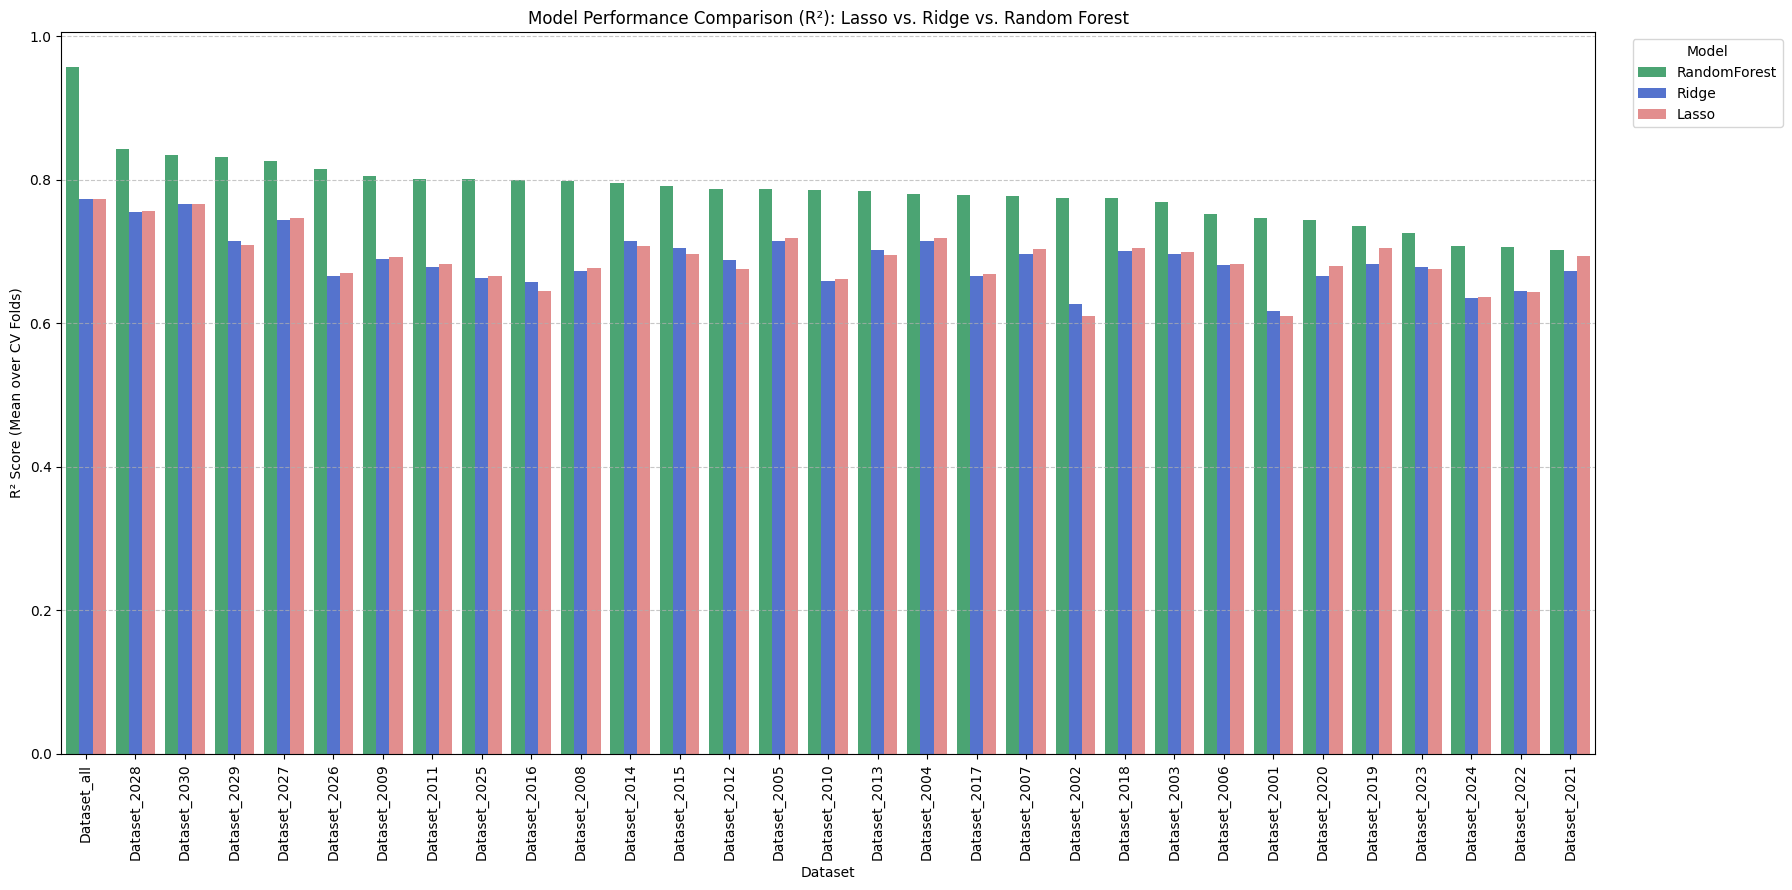

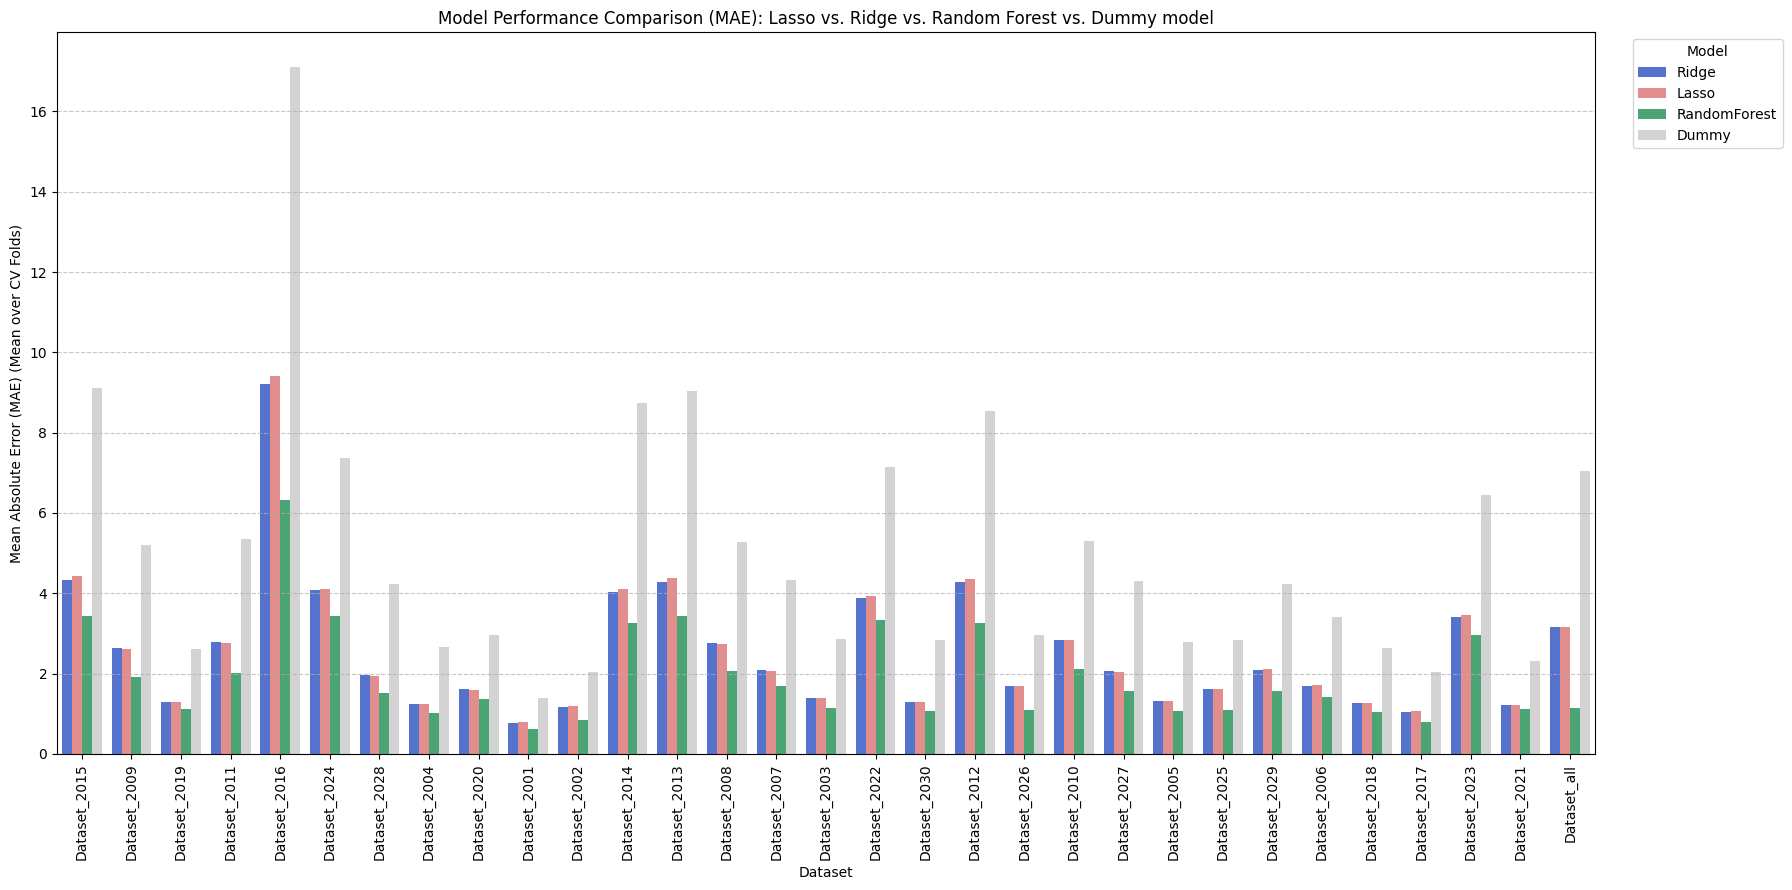

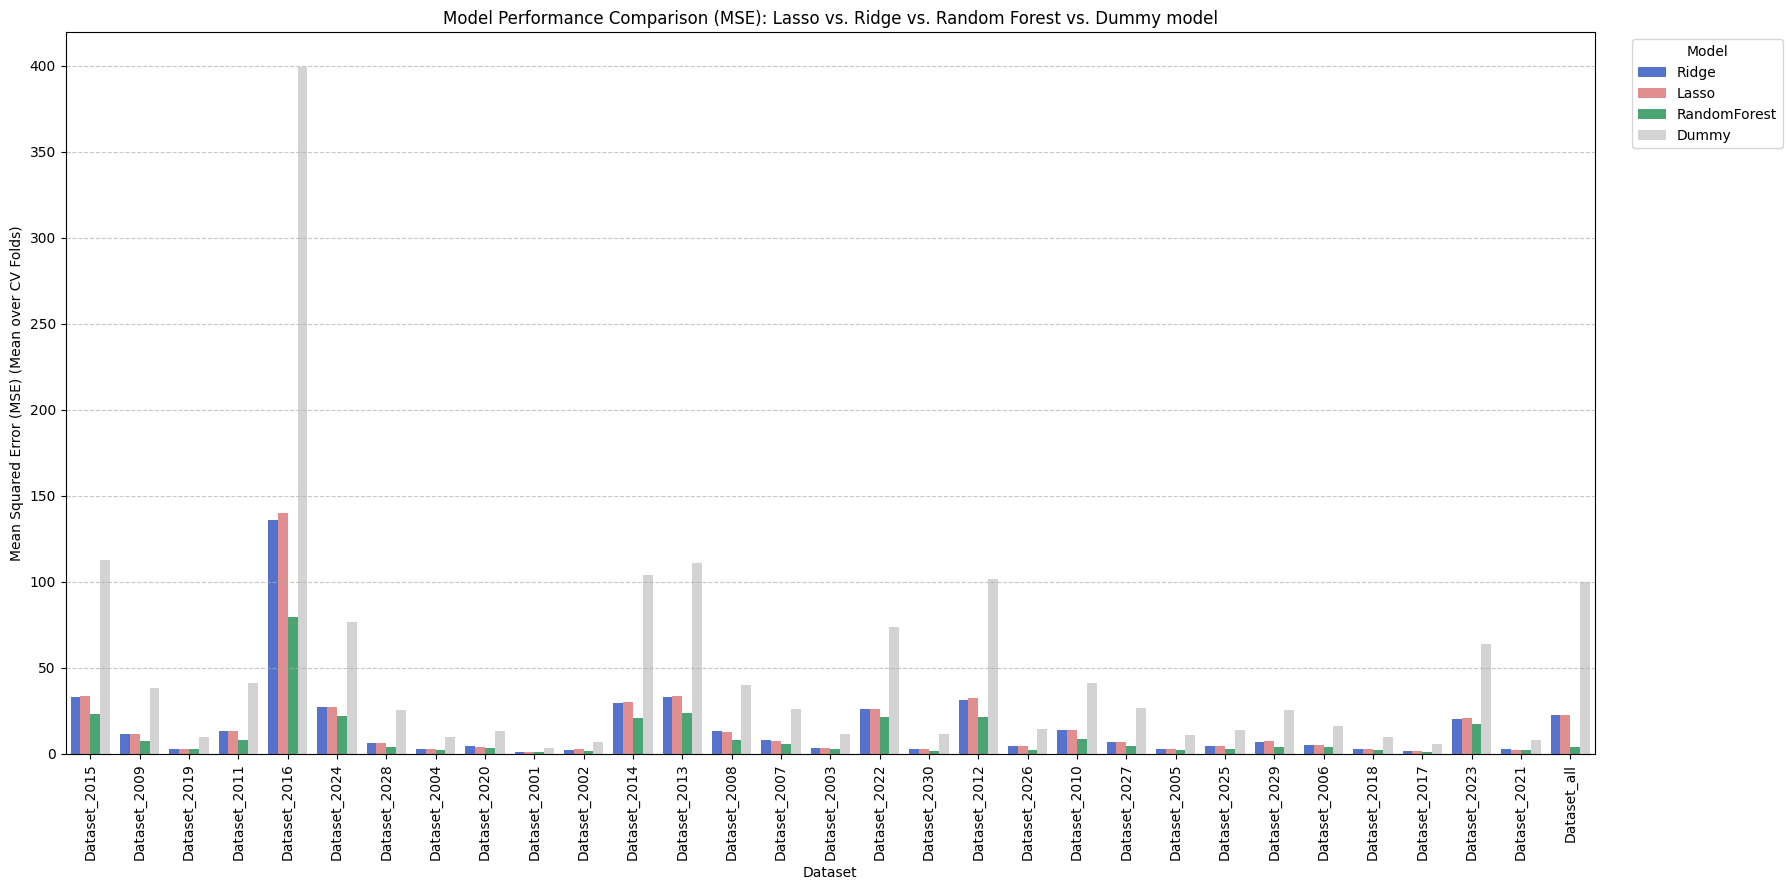

In [ ]:
#Selecting results I want to compare
ridge_df_comp = ridge_df[['Dataset', 'Model', 'MAE', 'MAE_std', 'R2', 'R2_std', 'MSE', 'MSE_std']].copy()
lasso_df_comp = lasso_df[['Dataset', 'Model', 'MAE', 'MAE_std', 'R2', 'R2_std', 'MSE', 'MSE_std']].copy()
rf_df_comp = rf_results_df[['Dataset', 'Model', 'MAE', 'MAE_std', 'R2', 'R2_std', 'MSE', 'MSE_std']].copy()
# Combining the dataframes into a single one
combined_performance_df = pd.concat([ ridge_df_comp, lasso_df_comp,rf_df_comp ], ignore_index=True)
# Adding dummy models
combined_performance_df = pd.concat([combined_performance_df, dummy_rows_y_train], ignore_index=True)

print("--- Consolidated Modell performance summaries for comparison ---")
# Sorting first by dataset and then by R² -> Same datasets will be next to each other and R^2 descending
print(combined_performance_df.sort_values(by=['Dataset', 'R2'], ascending=[True, False]))


#R² Comparison
plt.figure(figsize=(18, 9))
combined_performance_df_without_dummy = combined_performance_df.sort_values(by=['R2'], ascending=[False])[combined_performance_df['Model'] != 'Dummy']
sns.barplot(x='Dataset', y='R2', hue='Model', data=combined_performance_df_without_dummy,
            palette={'Ridge': 'royalblue', 'Lasso': 'lightcoral', 'RandomForest': 'mediumseagreen'},
            capsize=0.05)
plt.ylabel('R² Score (Mean over CV Folds)')
plt.xlabel('Dataset')
plt.title('Model Performance Comparison (R²): Lasso vs. Ridge vs. Random Forest')
plt.xticks(rotation=90)
plt.legend(title='Model', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# MAE-Comparison
plt.figure(figsize=(18, 9))
sns.barplot(x='Dataset', y='MAE', hue='Model', data=combined_performance_df,
            palette={'Ridge': 'royalblue', 'Lasso': 'lightcoral', 'RandomForest': 'mediumseagreen', 'Dummy': 'lightgray'},
            capsize=0.05)
plt.ylabel('Mean Absolute Error (MAE) (Mean over CV Folds)')
plt.xlabel('Dataset')
plt.title('Model Performance Comparison (MAE): Lasso vs. Ridge vs. Random Forest vs. Dummy model')
plt.xticks(rotation=90)
plt.legend(title='Model', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# MSE Comparison
plt.figure(figsize=(18, 9))
sns.barplot(x='Dataset', y='MSE', hue='Model', data=combined_performance_df,
            palette={'Ridge': 'royalblue', 'Lasso': 'lightcoral', 'RandomForest': 'mediumseagreen', 'Dummy': 'lightgray'},
            capsize=0.05)
plt.ylabel('Mean Squared Error (MSE) (Mean over CV Folds)')
plt.xlabel('Dataset')
plt.title('Model Performance Comparison (MSE): Lasso vs. Ridge vs. Random Forest vs. Dummy model')
plt.xticks(rotation=90)
plt.legend(title='Model', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


#Final Model Evaluation on Unseen Test Data individual datasets

## Ridge

In [ ]:
ridge_final_test_results = []

print("--- Evaluating Final Ridge Models on Held-Out Test Data ---")

# Loop through each dataset in your pre-split dictionary
for dataset_name, data_parts in split_datasets.items():
    print(f"Evaluating Ridge Model of: {dataset_name}...")

    # Extract the pre-split training and testing data for the current dataset
    X_train = data_parts['X_train']
    y_train = data_parts['y_train']
    X_test = data_parts['X_test']
    y_test = data_parts['y_test']

    # Ensuring y_train and y_test are 1D Series or NumPy arrays
    # This prevents potential shape errors with scikit-learn models
    if isinstance(y_train, pd.DataFrame) and y_train.shape[1] == 1:
        y_train = y_train.iloc[:, 0]
    elif isinstance(y_train, np.ndarray) and y_train.ndim == 2 and y_train.shape[1] == 1:
        y_train = y_train.flatten()

    if isinstance(y_test, pd.DataFrame) and y_test.shape[1] == 1:
        y_test = y_test.iloc[:, 0]
    elif isinstance(y_test, np.ndarray) and y_test.ndim == 2 and y_test.shape[1] == 1:
        y_test = y_test.flatten()


    # --- Final Ridge Model Training ---
    ridge_best_alpha = ridge_df.loc[ridge_df['Dataset'] == dataset_name, 'Alpha'].iloc[0]

    ridge_pipeline = make_pipeline(StandardScaler(), Ridge(alpha=ridge_best_alpha, random_state=42))

    # Train the final Ridge model on the entire training split
    ridge_pipeline.fit(X_train, y_train)

    # --- Final Ridge Model Evaluation ---
    # Make predictions on the held-out test split
    ridge_preds = ridge_pipeline.predict(X_test)

    # Calculate performance metrics
    r2 = r2_score(y_test, ridge_preds)
    mae = mean_absolute_error(y_test, ridge_preds)
    mse = mean_squared_error(y_test, ridge_preds)

    ridge_final_test_results.append({
        'Dataset': dataset_name,
        'Model': 'Ridge',
        'MAE_test': mae,
        'MSE_test': mse,
        'R2_test': r2,
    })

# Convert the list of results into a final DataFrame
ridge_final_test_df = pd.DataFrame(ridge_final_test_results)

print("\n--- Summary of Final Ridge Model Performance on Test Sets ---")
# Display the results, sorted by R2
print(ridge_final_test_df.sort_values(by='R2_test', ascending=False))

# Optional: Calculate and display overall averages on the test sets for Ridge
print("\n--- Overall Average Ridge Performance on Test Sets ---")
print(ridge_final_test_df[['MAE_test', 'MSE_test', 'R2_test']].mean())

--- Evaluating Final Ridge Models on Held-Out Test Data ---
Evaluating Ridge Model of: Dataset_2015...
Evaluating Ridge Model of: Dataset_2009...
Evaluating Ridge Model of: Dataset_2019...
Evaluating Ridge Model of: Dataset_2011...
Evaluating Ridge Model of: Dataset_2016...
Evaluating Ridge Model of: Dataset_2024...
Evaluating Ridge Model of: Dataset_2028...
Evaluating Ridge Model of: Dataset_2004...
Evaluating Ridge Model of: Dataset_2020...
Evaluating Ridge Model of: Dataset_2001...
Evaluating Ridge Model of: Dataset_2002...
Evaluating Ridge Model of: Dataset_2014...
Evaluating Ridge Model of: Dataset_2013...
Evaluating Ridge Model of: Dataset_2008...
Evaluating Ridge Model of: Dataset_2007...
Evaluating Ridge Model of: Dataset_2003...
Evaluating Ridge Model of: Dataset_2022...
Evaluating Ridge Model of: Dataset_2030...
Evaluating Ridge Model of: Dataset_2012...
Evaluating Ridge Model of: Dataset_2026...
Evaluating Ridge Model of: Dataset_2010...
Evaluating Ridge Model of: Dataset_20

## Lasso

In [ ]:
lasso_final_test_results = []

print("--- Evaluating Final Lasso Models on Held-Out Test Data ---")

# Loop through each dataset in your pre-split dictionary
for dataset_name, data_parts in split_datasets.items():
    print(f"Evaluating Lasso Model for: {dataset_name}...")

    # Extract the pre-split training and testing data for the current dataset
    X_train = data_parts['X_train']
    y_train = data_parts['y_train']
    X_test = data_parts['X_test']
    y_test = data_parts['y_test']

    # Endsuring y_train and y_test are 1D Series or NumPy arrays
    if isinstance(y_train, pd.DataFrame) and y_train.shape[1] == 1:
        y_train = y_train.iloc[:, 0]
    elif isinstance(y_train, np.ndarray) and y_train.ndim == 2 and y_train.shape[1] == 1:
        y_train = y_train.flatten()

    if isinstance(y_test, pd.DataFrame) and y_test.shape[1] == 1:
        y_test = y_test.iloc[:, 0]
    elif isinstance(y_test, np.ndarray) and y_test.ndim == 2 and y_test.shape[1] == 1:
        y_test = y_test.flatten()


    # --- Final Lasso Model Training ---
    # Retrieve the best alpha for the current dataset from lasso_df
    lasso_best_alpha = lasso_df.loc[lasso_df['Dataset'] == dataset_name, 'Alpha'].iloc[0]

    # Create the Lasso pipeline with the best alpha and a sufficient max_iter
    lasso_pipeline = make_pipeline(StandardScaler(), Lasso(alpha=lasso_best_alpha, max_iter=10000, random_state=42))

    # Train the final Lasso model on the entire training split
    lasso_pipeline.fit(X_train, y_train)

    # --- Final Lasso Model Evaluation ---
    # Make predictions on the held-out test split
    lasso_preds = lasso_pipeline.predict(X_test)

    # Calculate performance metrics
    r2 = r2_score(y_test, lasso_preds)
    mae = mean_absolute_error(y_test, lasso_preds)
    mse = mean_squared_error(y_test, lasso_preds)

    lasso_final_test_results.append({
        'Dataset': dataset_name,
        'Model': 'Lasso',
        'MAE_test': mae,
        'MSE_test': mse,
        'R2_test': r2,
    })

# Convert the list of results into a final DataFrame
lasso_final_test_df = pd.DataFrame(lasso_final_test_results)

print("\n--- Summary of Final Lasso Model Performance on Test Sets ---")
# Display the results, sorted by R2
print(lasso_final_test_df.sort_values(by='R2_test', ascending=False))

# Optional: Calculate and display overall averages on the test sets for Lasso
print("\n--- Overall Average Lasso Performance on Test Sets ---")
print(lasso_final_test_df[['MAE_test', 'MSE_test', 'R2_test']].mean())

--- Evaluating Final Lasso Models on Held-Out Test Data ---
Evaluating Lasso Model for: Dataset_2015...
Evaluating Lasso Model for: Dataset_2009...
Evaluating Lasso Model for: Dataset_2019...
Evaluating Lasso Model for: Dataset_2011...
Evaluating Lasso Model for: Dataset_2016...
Evaluating Lasso Model for: Dataset_2024...
Evaluating Lasso Model for: Dataset_2028...
Evaluating Lasso Model for: Dataset_2004...
Evaluating Lasso Model for: Dataset_2020...
Evaluating Lasso Model for: Dataset_2001...
Evaluating Lasso Model for: Dataset_2002...
Evaluating Lasso Model for: Dataset_2014...
Evaluating Lasso Model for: Dataset_2013...
Evaluating Lasso Model for: Dataset_2008...
Evaluating Lasso Model for: Dataset_2007...
Evaluating Lasso Model for: Dataset_2003...
Evaluating Lasso Model for: Dataset_2022...
Evaluating Lasso Model for: Dataset_2030...
Evaluating Lasso Model for: Dataset_2012...
Evaluating Lasso Model for: Dataset_2026...
Evaluating Lasso Model for: Dataset_2010...
Evaluating Lasso

## **Random Forest**

In [ ]:
# Initialize a list to store the final test results for Random Forest
rf_final_test_results = []

print("--- Evaluating Final Random Forest Models on Held-Out Test Data ---")

# Loop through each dataset in your pre-split dictionary
for dataset_name, data_parts in split_datasets.items():
    print(f"Evaluating Random Forest Model for: {dataset_name}...")

    # Extract training and testing data for the current dataset
    X_train = data_parts['X_train']
    y_train = data_parts['y_train']
    X_test = data_parts['X_test']
    y_test = data_parts['y_test']


    # Endsuring y_train and y_test are 1D Series or NumPy arrays
    if isinstance(y_train, pd.DataFrame) and y_train.shape[1] == 1:
        y_train = y_train.iloc[:, 0]
    elif isinstance(y_train, np.ndarray) and y_train.ndim == 2 and y_train.shape[1] == 1:
        y_train = y_train.flatten()

    if isinstance(y_test, pd.DataFrame) and y_test.shape[1] == 1:
        y_test = y_test.iloc[:, 0]
    elif isinstance(y_test, np.ndarray) and y_test.ndim == 2 and y_test.shape[1] == 1:
        y_test = y_test.flatten()


    # --- Final Random Forest Model Training ---
    # Retrieve the best hyperparameters for the current dataset from rf_results_df
    rf_row = rf_results_df.loc[rf_results_df['Dataset'] == dataset_name].iloc[0]
    rf_best_n_estimators = int(rf_row['Best_N_Estimators'])
    rf_best_max_features = rf_row['Best_Max_Features']
    rf_best_min_samples_leaf = int(rf_row['Best_Min_Samples_Leaf'])
    # Create the Random Forest pipeline with the best hyperparameters
    rf_pipeline = make_pipeline(
        StandardScaler(),
        RandomForestRegressor(
            n_estimators=rf_best_n_estimators,
            max_features=rf_best_max_features,
            min_samples_leaf=rf_best_min_samples_leaf,
            random_state=42
        )
    )
    # --- Final Random Forest Model Training ---
    # Train the final Random Forest model on the entire training split
    rf_pipeline.fit(X_train, y_train)

     # --- Final Random Forest Model Evaluation ---
    # Make predictions on the held-out test split
    rf_preds = rf_pipeline.predict(X_test)

    # Calculate performance metrics
    r2 = r2_score(y_test, rf_preds)
    mae = mean_absolute_error(y_test, rf_preds)
    mse = mean_squared_error(y_test, rf_preds)

    rf_final_test_results.append({
        'Dataset': dataset_name,
        'Model': 'RandomForest',
        'MAE_test': mae,
        'MSE_test': mse,
        'R2_test': r2,
        'N_Est' : rf_best_n_estimators,
        'Max_Feat' : rf_best_max_features
    })

# Convert the list of results into a final DataFrame
rf_final_test_df = pd.DataFrame(rf_final_test_results)

print("\n--- Summary of Final Random Forest Model Performance on Test Sets ---")
# Display the results, sorted by R2
print(rf_final_test_df.sort_values(by='R2_test', ascending=False))

# Optional: Calculate and display overall averages on the test sets for Random Forest
print("\n--- Overall Average Random Forest Performance on Test Sets ---")
print(rf_final_test_df[['MAE_test', 'MSE_test', 'R2_test']].mean())

--- Evaluating Final Random Forest Models on Held-Out Test Data ---
Evaluating Random Forest Model for: Dataset_2015...
Evaluating Random Forest Model for: Dataset_2009...
Evaluating Random Forest Model for: Dataset_2019...
Evaluating Random Forest Model for: Dataset_2011...
Evaluating Random Forest Model for: Dataset_2016...
Evaluating Random Forest Model for: Dataset_2024...
Evaluating Random Forest Model for: Dataset_2028...
Evaluating Random Forest Model for: Dataset_2004...
Evaluating Random Forest Model for: Dataset_2020...
Evaluating Random Forest Model for: Dataset_2001...
Evaluating Random Forest Model for: Dataset_2002...
Evaluating Random Forest Model for: Dataset_2014...
Evaluating Random Forest Model for: Dataset_2013...
Evaluating Random Forest Model for: Dataset_2008...
Evaluating Random Forest Model for: Dataset_2007...
Evaluating Random Forest Model for: Dataset_2003...
Evaluating Random Forest Model for: Dataset_2022...
Evaluating Random Forest Model for: Dataset_2030

## Ridge for entire Dataset on unseen Test Data

--- Evaluating Final Ridge Model on Held-Out Test Data: Dataset_all ---

--- Final Ridge Model Performance on Dataset_all ---
       Dataset  Model  MAE_test   MSE_test   R2_test
0  Dataset_all  Ridge  3.163862  22.312649  0.792238

--- Average Ridge Performance on Dataset_all ---
MAE_test     3.163862
MSE_test    22.312649
R2_test      0.792238
dtype: float64


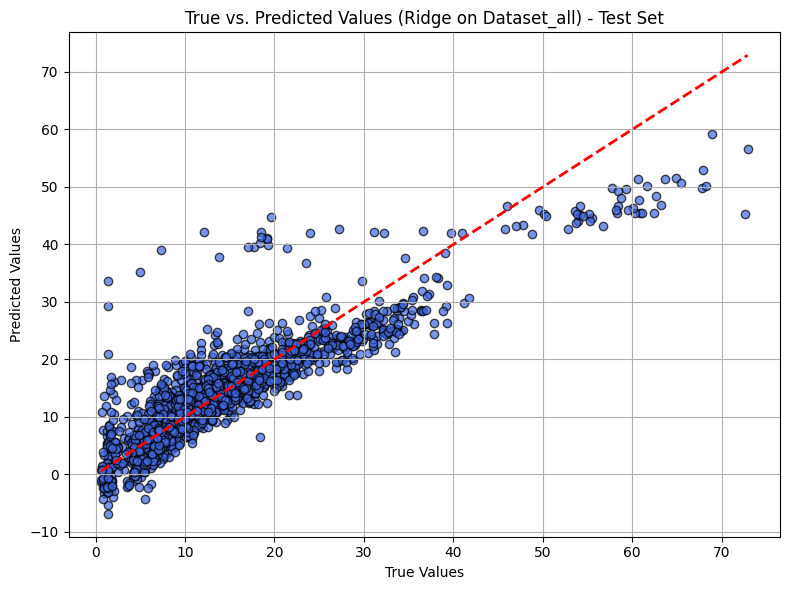

In [ ]:
ridge_final_test_results_dataset_all = []

print("--- Evaluating Final Ridge Model on Held-Out Test Data: Dataset_all ---")

# Specify dataset name
dataset_name = 'Dataset_all'

# Extract data for Dataset_all
data_parts = split_dataset_all[dataset_name]
X_train = data_parts['X_train_dataset_all']
y_train = data_parts['y_train_dataset_all']
X_test = data_parts['X_test_dataset_all']
y_test = data_parts['y_test_dataset_all']

# Ensure y arrays are 1D
if isinstance(y_train, pd.DataFrame) and y_train.shape[1] == 1:
    y_train = y_train.iloc[:, 0]
elif isinstance(y_train, np.ndarray) and y_train.ndim == 2 and y_train.shape[1] == 1:
    y_train = y_train.flatten()

if isinstance(y_test, pd.DataFrame) and y_test.shape[1] == 1:
    y_test = y_test.iloc[:, 0]
elif isinstance(y_test, np.ndarray) and y_test.ndim == 2 and y_test.shape[1] == 1:
    y_test = y_test.flatten()

# --- Final Ridge Model Training ---
ridge_best_alpha_dataset_all = ridge_df.loc[ridge_df['Dataset'] == dataset_name, 'Alpha'].iloc[0]
ridge_pipeline = make_pipeline(StandardScaler(), Ridge(alpha=ridge_best_alpha_dataset_all, random_state=42))

ridge_pipeline.fit(X_train, y_train)

# --- Evaluation ---
ridge_preds = ridge_pipeline.predict(X_test)

r2 = r2_score(y_test, ridge_preds)
mae = mean_absolute_error(y_test, ridge_preds)
mse = mean_squared_error(y_test, ridge_preds)

ridge_final_test_results_dataset_all.append({
    'Dataset': dataset_name,
    'Model': 'Ridge',
    'MAE_test': mae,
    'MSE_test': mse,
    'R2_test': r2,
})

# Results as DataFrame
ridge_final_test_df_dataset_all = pd.DataFrame(ridge_final_test_results_dataset_all)

print("\n--- Final Ridge Model Performance on Dataset_all ---")
print(ridge_final_test_df_dataset_all)

# Optional: Display overall mean (trivial here since it’s one row)
print("\n--- Average Ridge Performance on Dataset_all ---")
print(ridge_final_test_df_dataset_all[['MAE_test', 'MSE_test', 'R2_test']].mean())

# --- Plot True vs. Predicted Values on Test Set ---
plt.figure(figsize=(8, 6))
plt.scatter(y_test, ridge_preds, alpha=0.7, color='royalblue', edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title(f"True vs. Predicted Values (Ridge on Dataset_all) - Test Set")
plt.grid(True)
plt.tight_layout()
plt.show()

## Lasso for entire Dataset on unseen Test Data

--- Evaluating Final Lasso Model on Held-Out Test Data: Dataset_all ---

--- Final Lasso Model Performance on Dataset_all ---
       Dataset  Model  MAE_test  MSE_test   R2_test
0  Dataset_all  Lasso  3.162998  22.34917  0.791898

--- Average Lasso Performance on Dataset_all ---
MAE_test     3.162998
MSE_test    22.349170
R2_test      0.791898
dtype: float64


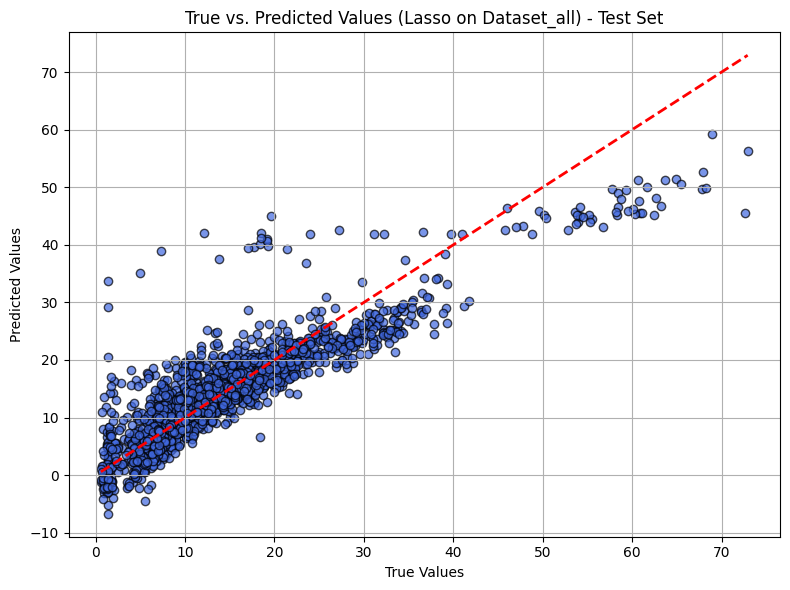

In [ ]:
lasso_final_test_results_dataset_all = []

print("--- Evaluating Final Lasso Model on Held-Out Test Data: Dataset_all ---")

# Specify dataset name
dataset_name = 'Dataset_all'

# Extract data for Dataset_all
data_parts = split_dataset_all[dataset_name]
X_train = data_parts['X_train_dataset_all']
y_train = data_parts['y_train_dataset_all']
X_test = data_parts['X_test_dataset_all']
y_test = data_parts['y_test_dataset_all']

# Ensure y arrays are 1D
if isinstance(y_train, pd.DataFrame) and y_train.shape[1] == 1:
    y_train = y_train.iloc[:, 0]
elif isinstance(y_train, np.ndarray) and y_train.ndim == 2 and y_train.shape[1] == 1:
    y_train = y_train.flatten()

if isinstance(y_test, pd.DataFrame) and y_test.shape[1] == 1:
    y_test = y_test.iloc[:, 0]
elif isinstance(y_test, np.ndarray) and y_test.ndim == 2 and y_test.shape[1] == 1:
    y_test = y_test.flatten()

# --- Final Lasso Model Training ---
lasso_best_alpha_dataset_all = lasso_df.loc[lasso_df['Dataset'] == dataset_name, 'Alpha'].iloc[0]

lasso_pipeline = make_pipeline(StandardScaler(), Lasso(alpha=lasso_best_alpha_dataset_all, max_iter=10000, random_state=42))

lasso_pipeline.fit(X_train, y_train)

# --- Final Lasso Model Evaluation ---
lasso_preds = lasso_pipeline.predict(X_test)

r2 = r2_score(y_test, lasso_preds)
mae = mean_absolute_error(y_test, lasso_preds)
mse = mean_squared_error(y_test, lasso_preds)

lasso_final_test_results_dataset_all.append({
    'Dataset': dataset_name,
    'Model': 'Lasso',
    'MAE_test': mae,
    'MSE_test': mse,
    'R2_test': r2,
})

# Convert results to DataFrame
lasso_final_test_df_dataset_all = pd.DataFrame(lasso_final_test_results_dataset_all)

print("\n--- Final Lasso Model Performance on Dataset_all ---")
print(lasso_final_test_df_dataset_all)

# Optional: Show average (only 1 row, but retained for structure)
print("\n--- Average Lasso Performance on Dataset_all ---")
print(lasso_final_test_df_dataset_all[['MAE_test', 'MSE_test', 'R2_test']].mean())

# --- Plot True vs. Predicted Values on Test Set ---
plt.figure(figsize=(8, 6))
plt.scatter(y_test, lasso_preds, alpha=0.7, color='royalblue', edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title(f"True vs. Predicted Values (Lasso on Dataset_all) - Test Set")
plt.grid(True)
plt.tight_layout()
plt.show()

## Random Forest for entire Dataset on unseen Test Data

--- Evaluating Final Random Forest Model on Held-Out Test Data: Dataset_all ---

--- Final Random Forest Model Performance on Dataset_all ---
       Dataset         Model  MAE_test  MSE_test   R2_test  N_Est  Max_Feat
0  Dataset_all  RandomForest  1.090132   4.84454  0.954891    100       0.6

--- Average Random Forest Performance on Dataset_all ---
MAE_test    1.090132
MSE_test    4.844540
R2_test     0.954891
dtype: float64


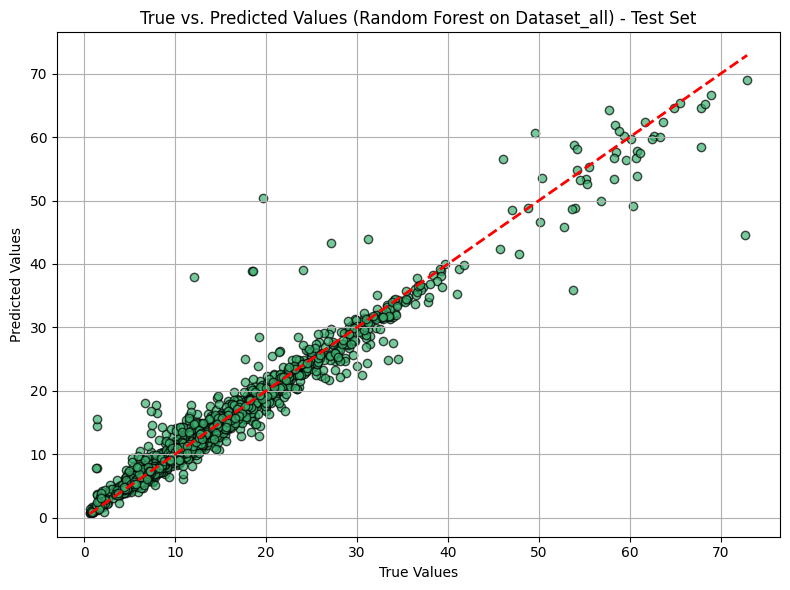

In [ ]:
# Initialize a list to store the final test results for Random Forest
rf_final_test_results_dataset_all= []

print("--- Evaluating Final Random Forest Model on Held-Out Test Data: Dataset_all ---")

# Specify dataset name
dataset_name = 'Dataset_all'

# Extract training and testing data for Dataset_all
data_parts = split_dataset_all[dataset_name]
X_train = data_parts['X_train_dataset_all']
y_train = data_parts['y_train_dataset_all']
X_test = data_parts['X_test_dataset_all']
y_test = data_parts['y_test_dataset_all']

# Ensuring y_train and y_test are 1D Series or NumPy arrays
if isinstance(y_train, pd.DataFrame) and y_train.shape[1] == 1:
    y_train = y_train.iloc[:, 0]
elif isinstance(y_train, np.ndarray) and y_train.ndim == 2 and y_train.shape[1] == 1:
    y_train = y_train.flatten()

if isinstance(y_test, pd.DataFrame) and y_test.shape[1] == 1:
    y_test = y_test.iloc[:, 0]
elif isinstance(y_test, np.ndarray) and y_test.ndim == 2 and y_test.shape[1] == 1:
    y_test = y_test.flatten()

# --- Final Random Forest Model Training ---
# Retrieve the best hyperparameters for Dataset_all
rf_row = rf_results_df.loc[rf_results_df['Dataset'] == dataset_name].iloc[0]
rf_best_n_estimators = int(rf_row['Best_N_Estimators'])
rf_best_max_features = rf_row['Best_Max_Features']
rf_best_min_samples_leaf = int(rf_row['Best_Min_Samples_Leaf'])

# Create the pipeline
rf_pipeline = make_pipeline(
    StandardScaler(),
    RandomForestRegressor(
        n_estimators=rf_best_n_estimators,
        max_features=rf_best_max_features,
        min_samples_leaf=rf_best_min_samples_leaf,
        random_state=42
    )
)

# Train the final model
rf_pipeline.fit(X_train, y_train)

# --- Evaluation ---
rf_preds = rf_pipeline.predict(X_test)

r2 = r2_score(y_test, rf_preds)
mae = mean_absolute_error(y_test, rf_preds)
mse = mean_squared_error(y_test, rf_preds)

rf_final_test_results_dataset_all.append({
    'Dataset': dataset_name,
    'Model': 'RandomForest',
    'MAE_test': mae,
    'MSE_test': mse,
    'R2_test': r2,
    'N_Est': rf_best_n_estimators,
    'Max_Feat': rf_best_max_features
})

# Convert results to DataFrame
rf_final_test_df = pd.DataFrame(rf_final_test_results_dataset_all)

print("\n--- Final Random Forest Model Performance on Dataset_all ---")
print(rf_final_test_df)

# Optional: Display overall averages (just one row here)
print("\n--- Average Random Forest Performance on Dataset_all ---")
print(rf_final_test_df[['MAE_test', 'MSE_test', 'R2_test']].mean())

# --- Plot True vs. Predicted Values on Test Set ---
plt.figure(figsize=(8, 6))
plt.scatter(y_test, rf_preds, alpha=0.7, color='mediumseagreen', edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title(f"True vs. Predicted Values (Random Forest on Dataset_all) - Test Set")
plt.grid(True)
plt.tight_layout()
plt.show()

## Combining results from the individual models with the ones from dataset_all

In [ ]:
ridge_final_test_results.extend(ridge_final_test_results_dataset_all)
ridge_final_test_df = pd.DataFrame(ridge_final_test_results)
lasso_final_test_results.extend(lasso_final_test_results_dataset_all)
lasso_final_test_df = pd.DataFrame(lasso_final_test_results)
rf_final_test_results.extend(rf_final_test_results_dataset_all)
rf_final_test_df = pd.DataFrame(rf_final_test_results)


## Creating Dummy Model

In [ ]:
print(f" \n Creating Dummy model for the used Data") # Here: y_test

dummy_rows = []

for dataset_name, data_parts in split_datasets.items():
    y_test = data_parts['y_test']

    dummy_mean = np.mean(y_test)
    y_dummy_pred = np.full_like(y_test, fill_value=dummy_mean, dtype=np.float64)

    mae = mean_absolute_error(y_test, y_dummy_pred)
    mse = mean_squared_error(y_test, y_dummy_pred)
    r2 = r2_score(y_test, y_dummy_pred)

    dummy_rows.append({
        'Dataset': dataset_name,
        'Model': 'Dummy',
        'MAE_test': mae,
        'MAE_std_test': np.nan,  # No CV, so std is unknown
        'MSE_test': mse,
        'MSE_std_test': np.nan,  # No CV, so std is unknown
        'R2_test': r2            # Should be 0 because dummy predicts mean
    })

# For dataset_all:
y_test = split_dataset_all['Dataset_all']['y_test_dataset_all']

dummy_mean = np.mean(y_test)
y_dummy_pred = np.full_like(y_test, fill_value=dummy_mean, dtype=np.float64)

mae = mean_absolute_error(y_test, y_dummy_pred)
mse = mean_squared_error(y_test, y_dummy_pred)
r2 = r2_score(y_test, y_dummy_pred)
dummy_rows.append({
    'Dataset': 'Dataset_all',
    'Model': 'Dummy',
    'MAE_test': mae,
    'MAE_std_test': np.nan,  # No CV, so std is unknown
    'MSE_test': mse,
    'MSE_std_test': np.nan,  # No CV, so std is unknown
    'R2_test': r2
})
dummy_rows_y_test = pd.DataFrame(dummy_rows)
print(f" \n Dummy model ready")

 
 Creating Dummy model for the used Data
 
 Dummy model ready


## Comparing Model Performance : Plots

--- Consolidated Final Test Set Performance for Comparison ---
          Dataset         Model  MAE_test    MSE_test   R2_test  N_Est  \
71   Dataset_2001  RandomForest  0.607419    0.619699  0.797011   50.0   
9    Dataset_2001         Ridge  0.782860    0.997425  0.673282    NaN   
40   Dataset_2001         Lasso  0.786345    0.999209  0.672698    NaN   
102  Dataset_2001         Dummy  1.393629    3.052864  0.000000    NaN   
72   Dataset_2002  RandomForest  0.855722    1.337479  0.809538  100.0   
..            ...           ...       ...         ...       ...    ...   
110  Dataset_2030         Dummy  2.723642   10.849791  0.000000    NaN   
92    Dataset_all  RandomForest  1.090132    4.844540  0.954891  100.0   
30    Dataset_all         Ridge  3.163862   22.312649  0.792238    NaN   
61    Dataset_all         Lasso  3.162998   22.349170  0.791898    NaN   
123   Dataset_all         Dummy  7.250149  107.395481  0.000000    NaN   

     Max_Feat  MAE_std_test  MSE_std_test  
71  

/tmp/ipython-input-27-1188842096.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  all_models_final_test_df_without_dummy = all_models_final_test_df.sort_values(by=['R2_test'], ascending=[False])[all_models_final_test_df['Model'] != 'Dummy']


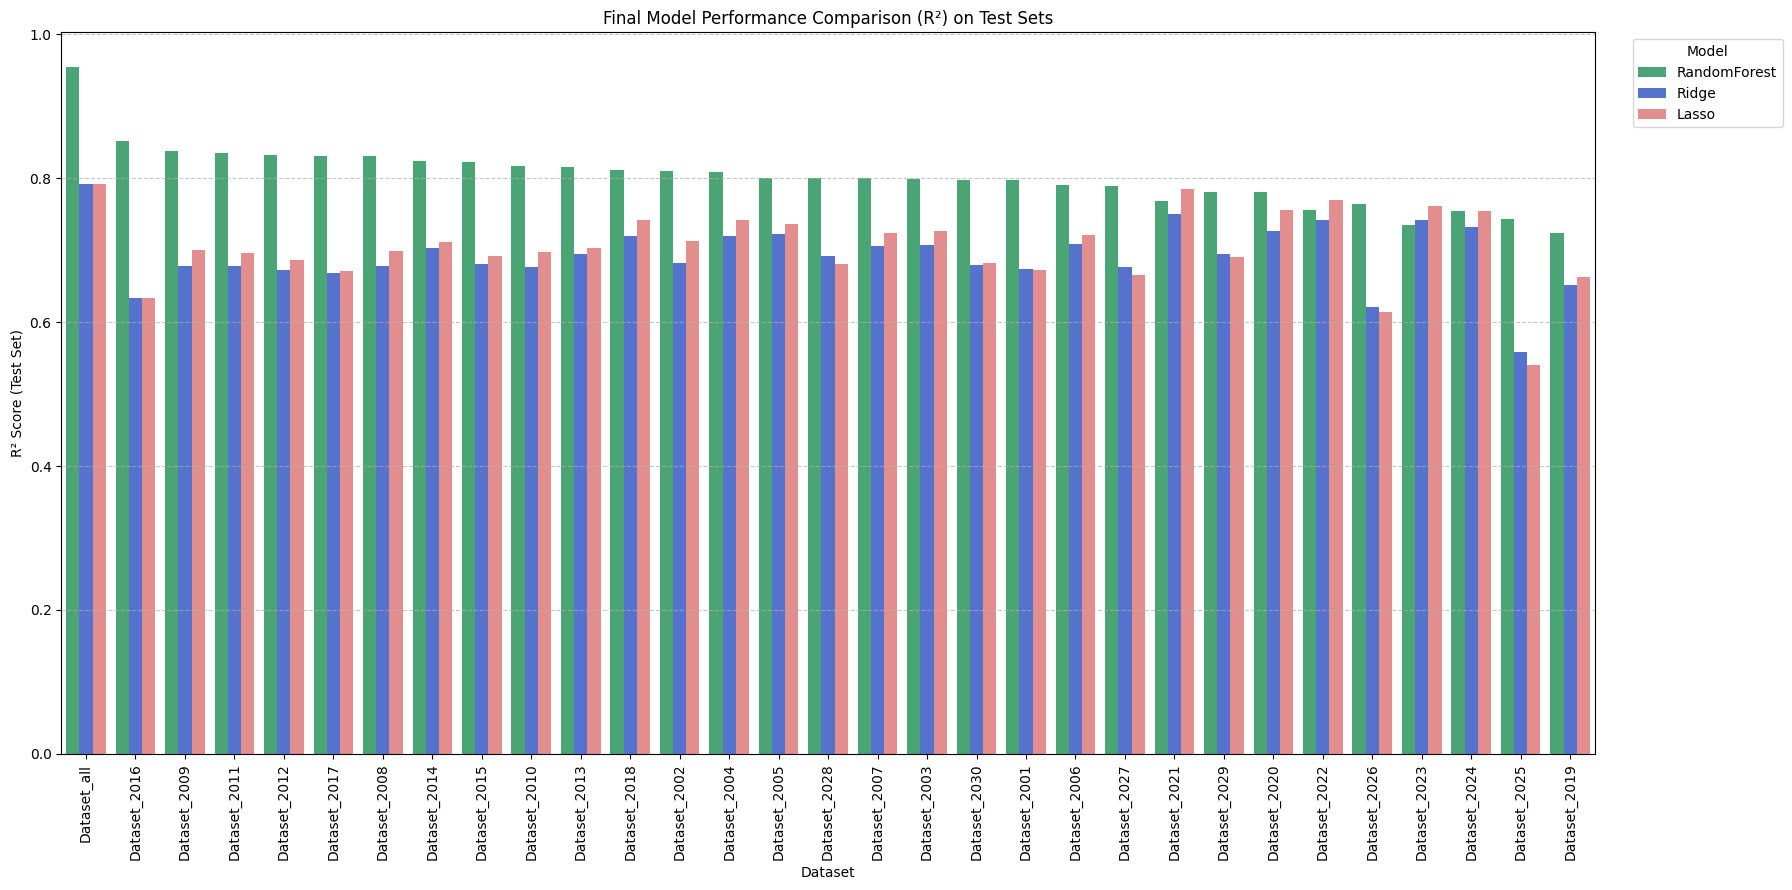

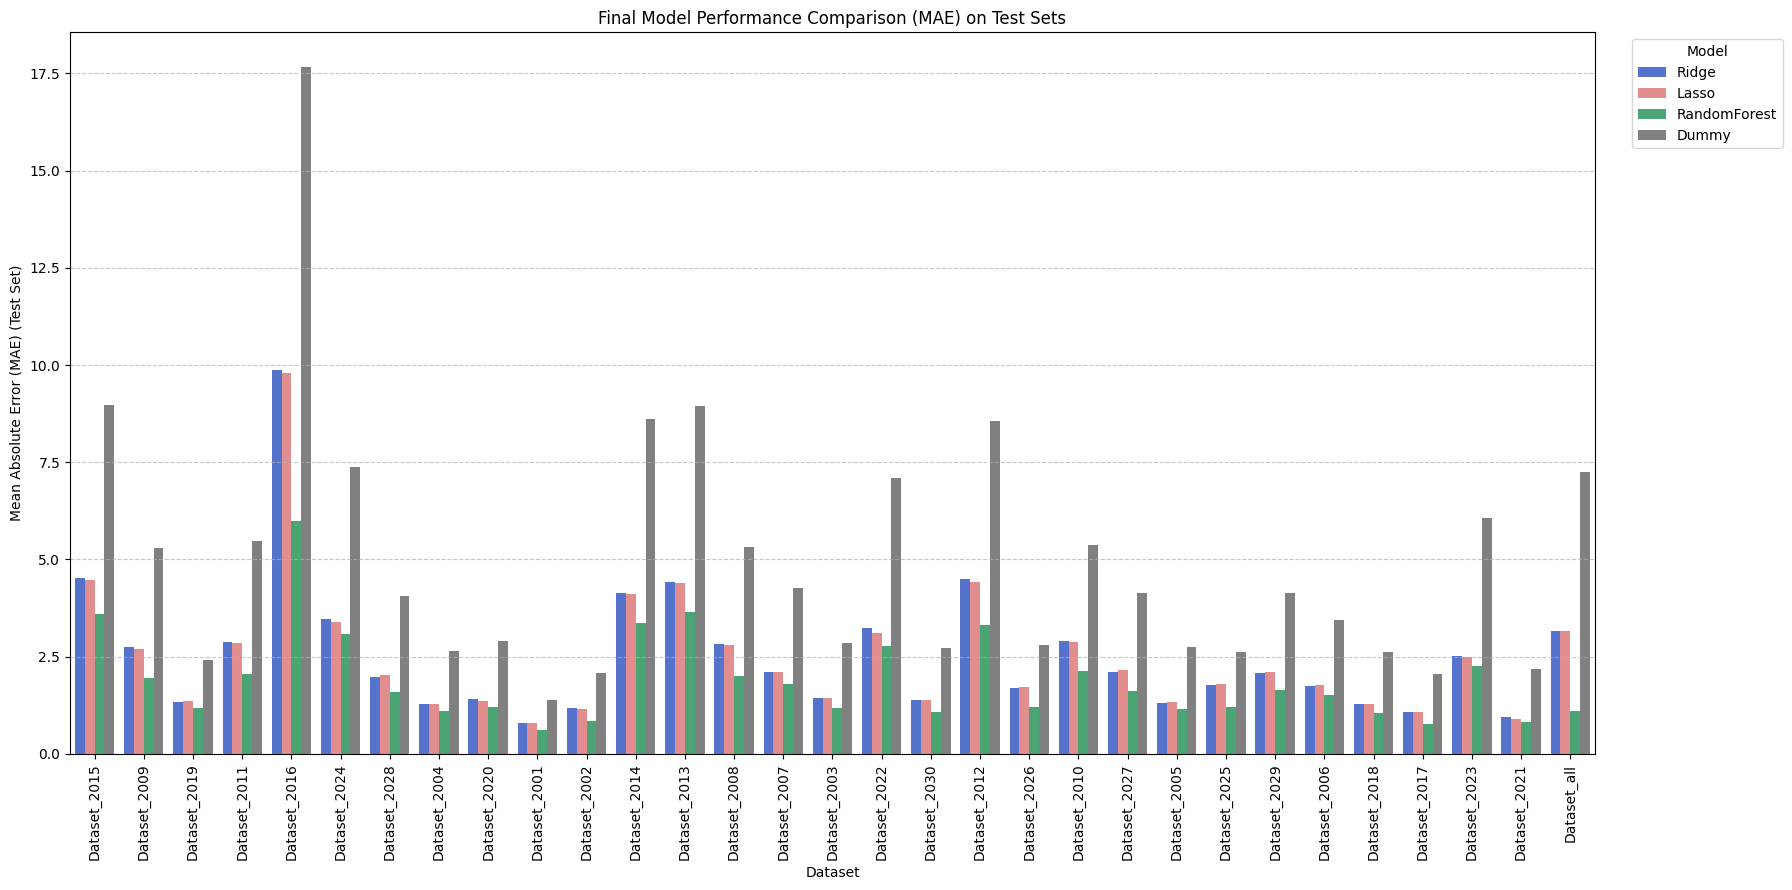

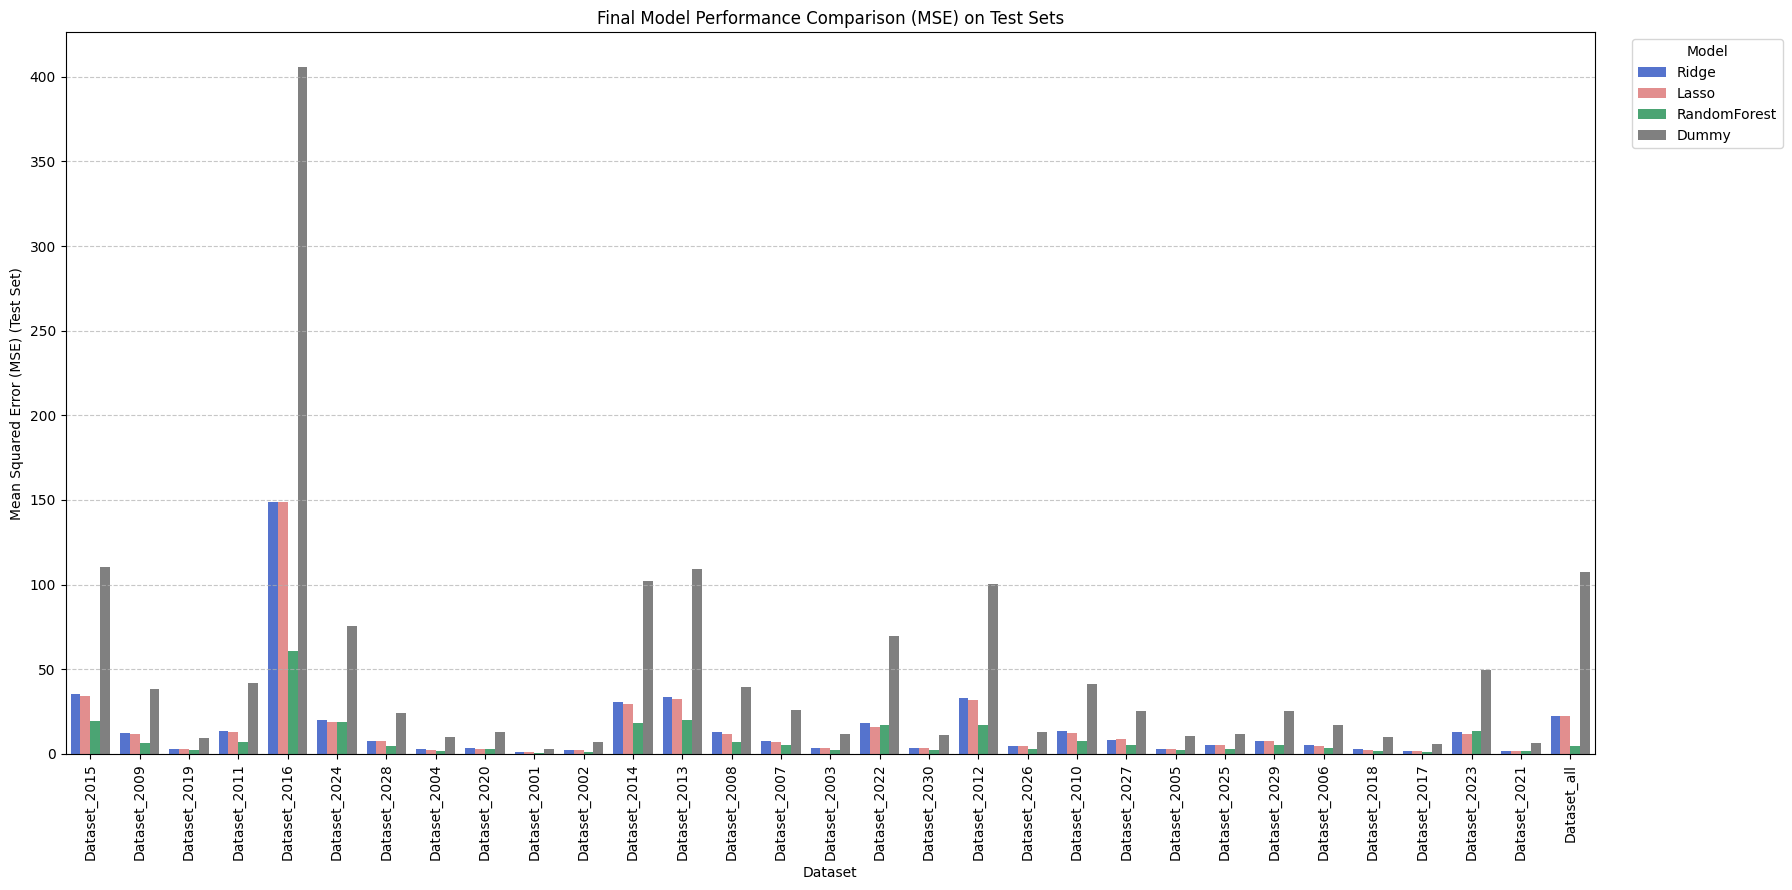

In [ ]:
# Combine the individual final test performance dataframes into a single one
all_models_final_test_df = pd.concat([
    ridge_final_test_df,
    lasso_final_test_df,
    rf_final_test_df
], ignore_index=True)

# Adding dummy models
all_models_final_test_df = pd.concat([all_models_final_test_df, dummy_rows_y_test], ignore_index=True)

print("--- Consolidated Final Test Set Performance for Comparison ---")
# Sorting first by dataset and then by R2_test to see which model performed best per dataset
print(all_models_final_test_df.sort_values(by=['Dataset', 'R2_test'], ascending=[True, False]))


model_palette = {
    'Ridge': 'royalblue',
    'Lasso': 'lightcoral',
    'RandomForest': 'mediumseagreen',
    'Dummy': 'gray'
}

# --- R² Test Performance Comparison ---
plt.figure(figsize=(18, 9))
all_models_final_test_df_without_dummy = all_models_final_test_df.sort_values(by=['R2_test'], ascending=[False])[all_models_final_test_df['Model'] != 'Dummy']
sns.barplot(x='Dataset', y='R2_test', hue='Model', data=all_models_final_test_df_without_dummy,
            palette={'Ridge': 'royalblue', 'Lasso': 'lightcoral', 'RandomForest': 'mediumseagreen'},
            capsize=0.05)
plt.ylabel('R² Score (Test Set)')
plt.xlabel('Dataset')
plt.title('Final Model Performance Comparison (R²) on Test Sets')
plt.xticks(rotation=90)
plt.legend(title='Model', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# --- MAE Test Performance Comparison ---
plt.figure(figsize=(18, 9))
sns.barplot(x='Dataset', y='MAE_test', hue='Model', data=all_models_final_test_df,
            palette=model_palette,
            capsize=0.05)
plt.ylabel('Mean Absolute Error (MAE) (Test Set)')
plt.xlabel('Dataset')
plt.title('Final Model Performance Comparison (MAE) on Test Sets')
plt.xticks(rotation=90)
plt.legend(title='Model', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# --- MSE Test Performance Comparison ---
plt.figure(figsize=(18, 9))
sns.barplot(x='Dataset', y='MSE_test', hue='Model', data=all_models_final_test_df,
            palette=model_palette,
            capsize=0.05)
plt.ylabel('Mean Squared Error (MSE) (Test Set)')
plt.xlabel('Dataset')
plt.title('Final Model Performance Comparison (MSE) on Test Sets')
plt.xticks(rotation=90)
plt.legend(title='Model', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()